# House Rent Prediction with XGBoost Optuna Hyperparam. Tunning

# Dataset Content 

In this Dataset, we have information on almost 4700+ Houses/Apartments/Flats Available for Rent with different parameters like BHK, Rent, Size, No. of Floors, Area Type, Area Locality, City, Furnishing Status, Type of Tenant Preferred, No. of Bathrooms, Point of Contact.

| Column Name      | Criteria                                                                                                                                                                    |
|------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| BHK              | Numeric , Number of Bedrooms, Hall, Kitchen.                                                                                                                                |
| Rent             | Numeric , Rent of the Houses/Apartments/Flats.                                                                                                                              |
| Size             | Numeric , Size of the Houses/Apartments/Flats in Square Feet.                                                                                                                |
| Floor            | Numeric , Houses/Apartments/Flats situated in which Floor and Total Number of Floors (Example: Ground out of 2, 3 out of 5, etc.)                                            |
| Area Type        | Character , Size of the Houses/Apartments/Flats calculated on either Super Area or Carpet Area or Build Area.                                                                |
| Area Locality    | Character , Locality of the Houses/Apartments/Flats.                                                                                                                        |
| City             | Character, City where the Houses/Apartments/Flats are Located.                                                                                                              |
| Furnishing Status| Character, Furnishing Status of the Houses/Apartments/Flats, either it is Furnished or Semi-Furnished or Unfurnished.                                                        |
| Point of Contact | Character, Whom should you contact for more information regarding the Houses/Apartments/Flats.                                                                              |
| Tenant Preferred | Character, Type of Tenant Preferred by the Owner or Agent.
                                 


### -> Import Libraries


In [1]:
%pip install dython
%pip install optuna
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode(connected = True)
from plotly.colors import n_colors
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import optuna
params_list=[]

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [6]:
from IPython.display import HTML as html_print
from IPython.display import display

def cstr(s, color='red'):
    return "<p style=color:{};font-size:21px;>{}</p>".format(color, s)

### Take a first look

In [2]:
csv=pd.read_csv("/kaggle/input/house-rent-prediction-dataset/House_Rent_Dataset.csv")
csv.head(5)

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


### ->Convert Date Type

In [3]:
csv['Posted On']=pd.to_datetime(csv['Posted On'],format='%Y-%m-%d')
print(csv['Posted On'].dtypes)

datetime64[ns]


### Dedection for Features Type

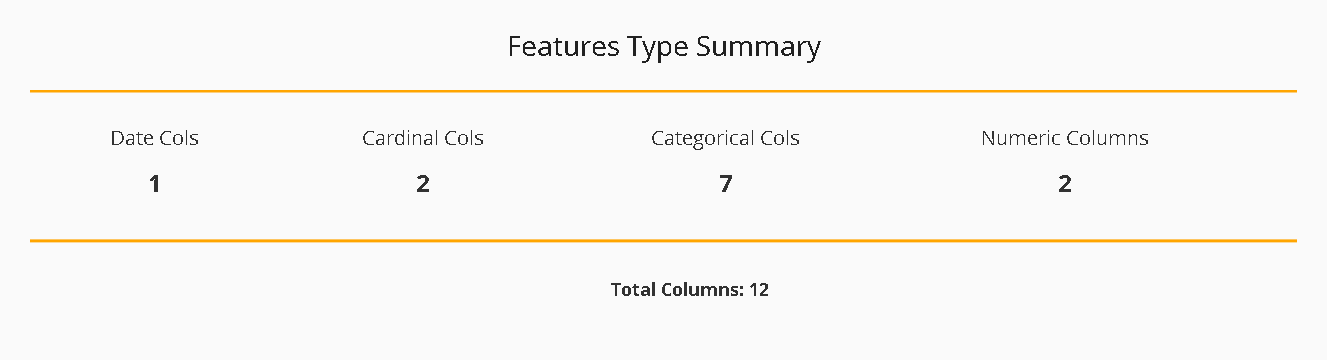

In [4]:
def dedect_features(df,nc_th=20,cn_th=30):
    '''
    Parameters
    ----------
    df : DataFrame
        Main Df
    nc_th : Integer, 
        Numeric but categorical threshold limit. The default is 20.
    cn_th : Integer, 
        Categorical but numeric threshold limit. The default is 30.

    Returns
    -------
    date_cols : List
        Date Types Columns List.
    num_but_cat : List
        Numeric but Categorical Types Columns List.
    cat_col : List
        Categorical Types Columns List.
    cat_but_num : List
        Categorical but Numeric Columns List.
    num_col : List
        Date Types Columns List.

    '''
    date_cols=[col for col in df if df[col].dtypes=="datetime64[ns]"]
    
    num_but_cat=[col for col in df.select_dtypes(['float','integer']).columns if df[col].value_counts().shape[0]<nc_th]
    cat_col=df.select_dtypes(['object','category']).columns.to_list()+num_but_cat
    cat_but_num=[col for col in df.select_dtypes(['object','category']).columns if df[col].value_counts().shape[0]>cn_th]
    cat_col=[col for col in cat_col if col not in cat_but_num]
    
    num_col=df.select_dtypes(['integer','float']).columns.to_list()
    num_col=[col for col in num_col if col not in num_but_cat]
    
    fig0=go.Figure()
    fig0.add_trace(go.Scatter(
        x=[0.2,1.7,3.4,5.3],
        y=[1.7, 1.7, 1.7, 1.7],
        mode="text",
        text=["Date Cols","Cardinal Cols","Categorical Cols","Numeric Columns", "Numeric but Cat. Columns"],
        textposition="bottom center"
        ))
    
    fig0.add_trace(go.Scatter(
    x=[0.2,1.7,3.4,5.3],
    y=[1.1, 1.1, 1.1, 1.1],
    mode="text", 
    text=["<span style='font-size:24px'><b>"+ str(len(date_cols)) +"</b></span>", 
          "<span style='font-size:24px'><b>"+ str(len(cat_but_num)) +"</b></span>",
          "<span style='font-size:24px'><b>"+ str(len(cat_col)) + "</b></span>",
          "<span style='font-size:24px'><b>"+ str(len(num_col)) + "</b></span>",
          "<span style='font-size:24px'><b>"+ str(len(num_but_cat)) + "</b></span>",
          "<span style='font-size:24px'><b>17</b></span>"],
    textposition="bottom center"
        ))
    fig0.add_hline(y=2.2, line_width=5, line_color='orange')
    fig0.add_hline(y=0.3, line_width=3, line_color='orange')
    fig0.add_trace(go.Scatter(
        x=[3.2],
        y=[-0.2],
        mode="text",
        text=["<span style='font-size:18px'><b>Total Columns: "+str(df.shape[1])+"</b></span>"],
        textposition="bottom center"
        ))
    fig0.update_yaxes(visible=False)
    fig0.update_xaxes(visible=False)
    fig0.update_layout(showlegend=False, height=300, width=900, 
                  title='Features Type Summary', title_x=0.5, title_y=0.9,
                  xaxis_range=[-0.5,6.6], yaxis_range=[-1.2,2.2],
                  plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                  font=dict(size=20, color='#323232'),
                  title_font=dict(size=28, color='#222'),
                  margin=dict(t=90,l=30,b=0,r=30), 
    )
    fig0.show()
    
    return date_cols,num_but_cat,cat_col,cat_but_num,num_col

date_cols,num_but_cat,cat_col,cat_but_num,num_col=dedect_features(csv)

## EDA

#### This class structure works with the detect_feature function. It allows us to get an overview and see data distributions. Our target variable appears to be a right-skewed distribution. Transformation methods can be tried with the 'Size' variable.



['describe', 'duplicate_val', 'info', 'missing_val', 'shape', 'types_feature', 'value_counts']


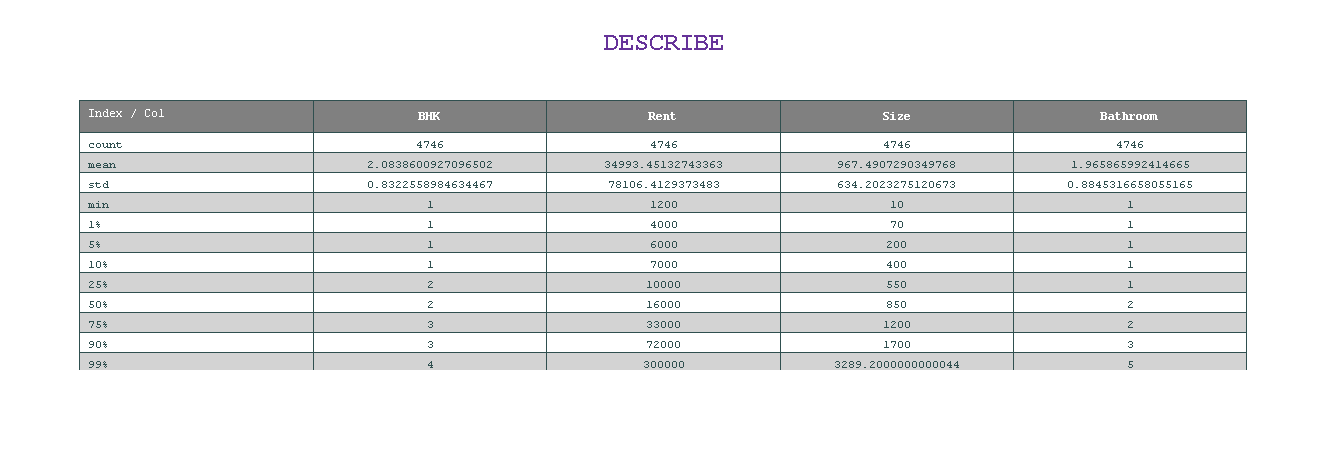

0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Posted On          4746 non-null   datetime64[ns]
 1   BHK                4746 non-null   int64         
 2   Rent               4746 non-null   int64         
 3   Size               4746 non-null   int64         
 4   Floor              4746 non-null   object        
 5   Area Type          4746 non-null   object        
 6   Area Locality      4746 non-null   object        
 7   City               4746 non-null   object        
 8   Furnishing Status  4746 non-null   object        
 9   Tenant Preferred   4746 non-null   object        
 10  Bathroom           4746 non-null   int64         
 11  Point of Contact   4746 non-null   object        
dtypes: datetime64[ns](1), int64(4), object(7)
memory usage: 445.1+ KB
None


                   0
Posted On          0
BHK                0
Rent               0
Size               0
Floor              0
Area Type          0
Area Locality      0
City               0
Furnishing Status  0
Tenant Preferred   0
Bathroom           0
Point of Contact   0


Observations: 4746 
 Features: 12 
 Shape Dataset: (4746, 12)


Posted On            datetime64[ns]
BHK                           int64
Rent                          int64
Size                          int64
Floor                        object
Area Type                    object
Area Locality                object
City                         object
Furnishing Status            object
Tenant Preferred             object
Bathroom                      int64
Point of Contact             object
dtype: object


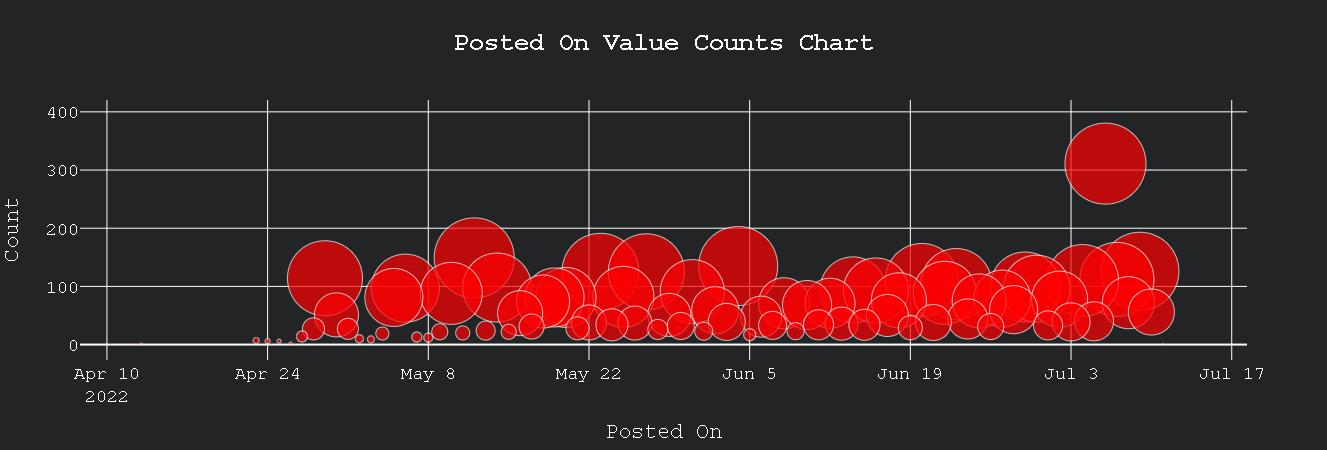

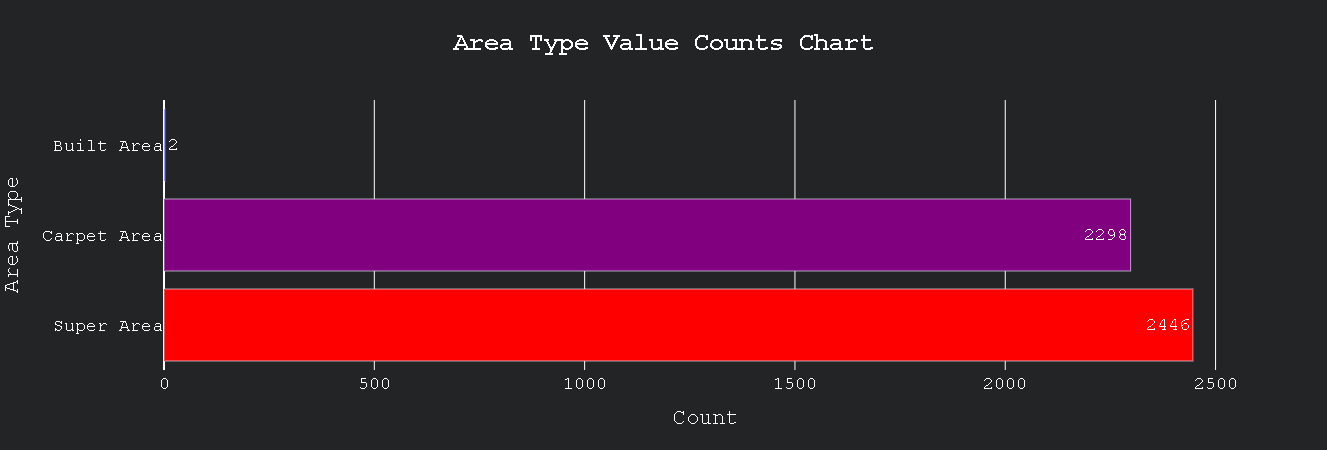

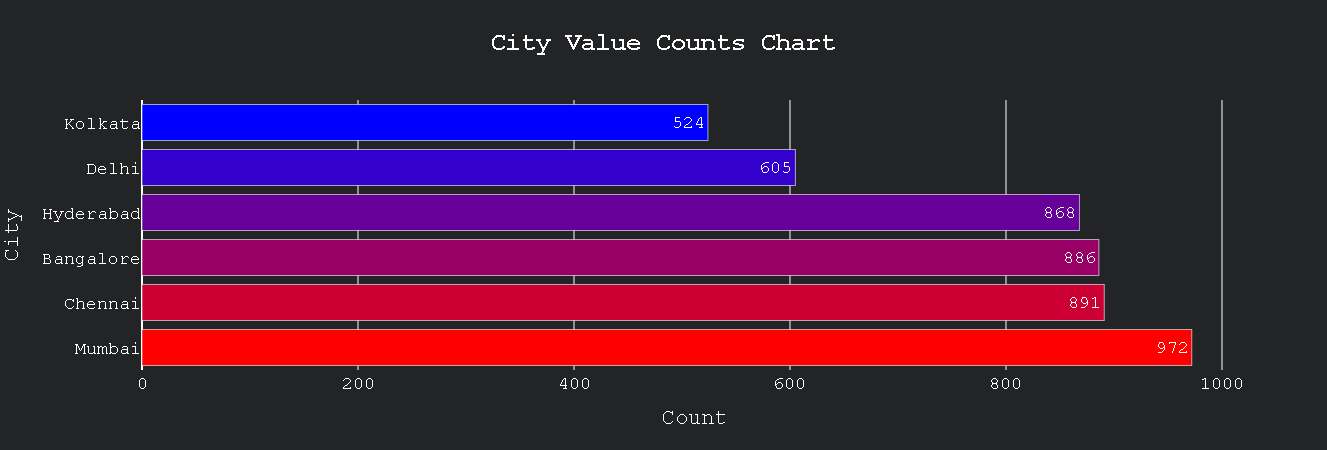

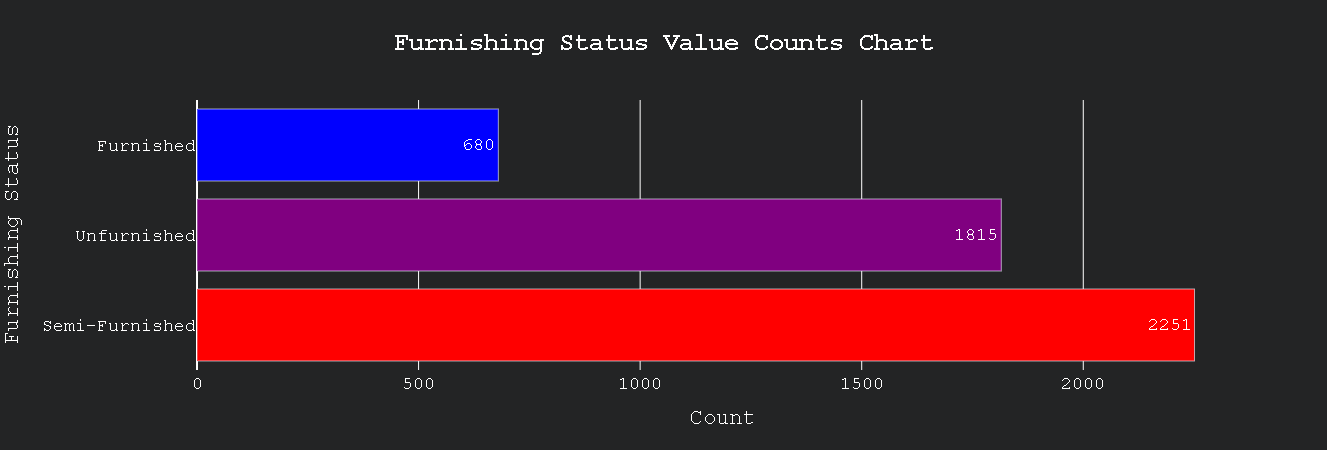

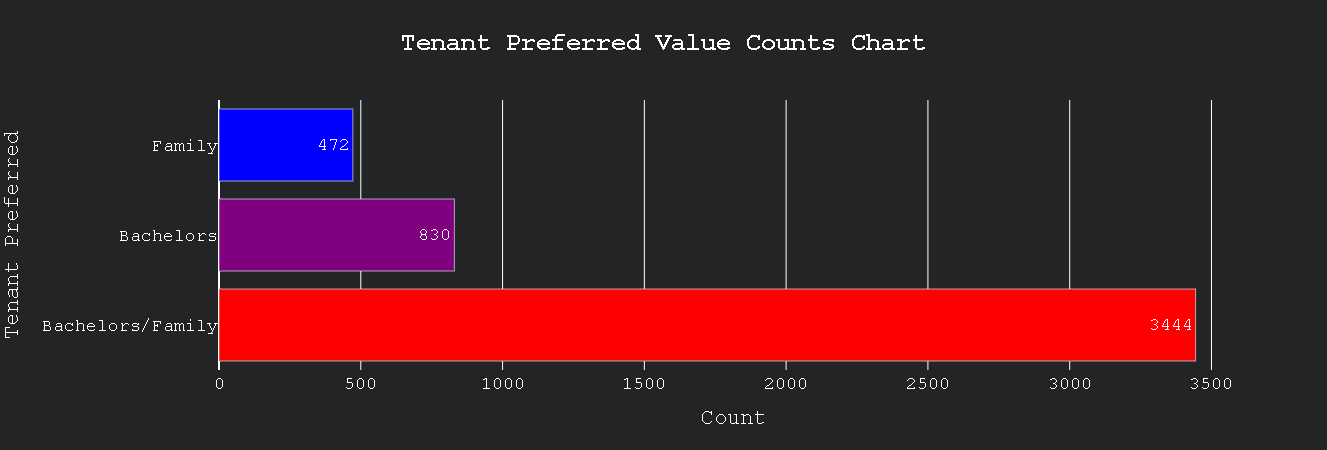

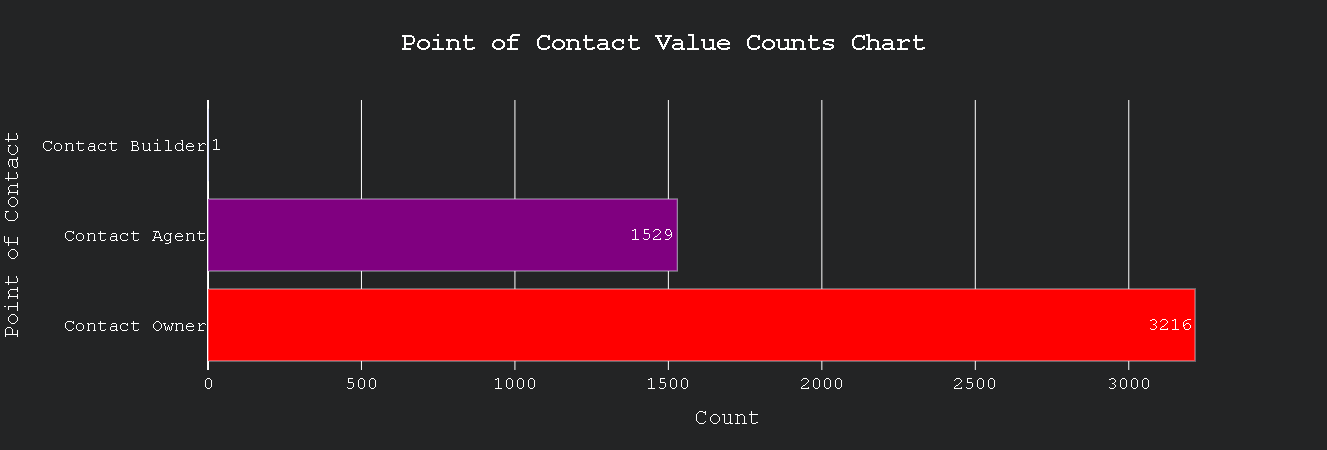

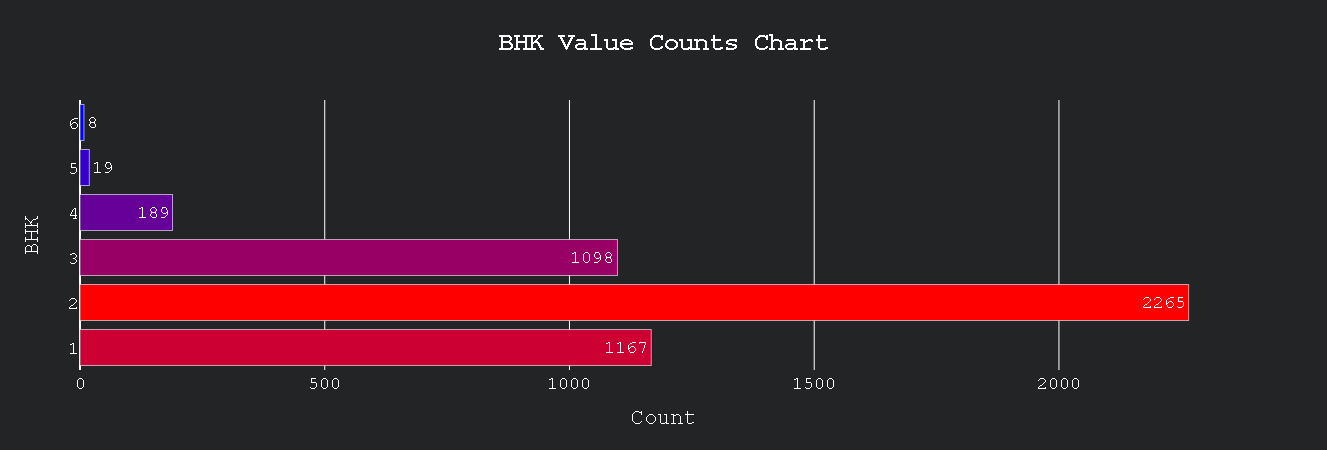

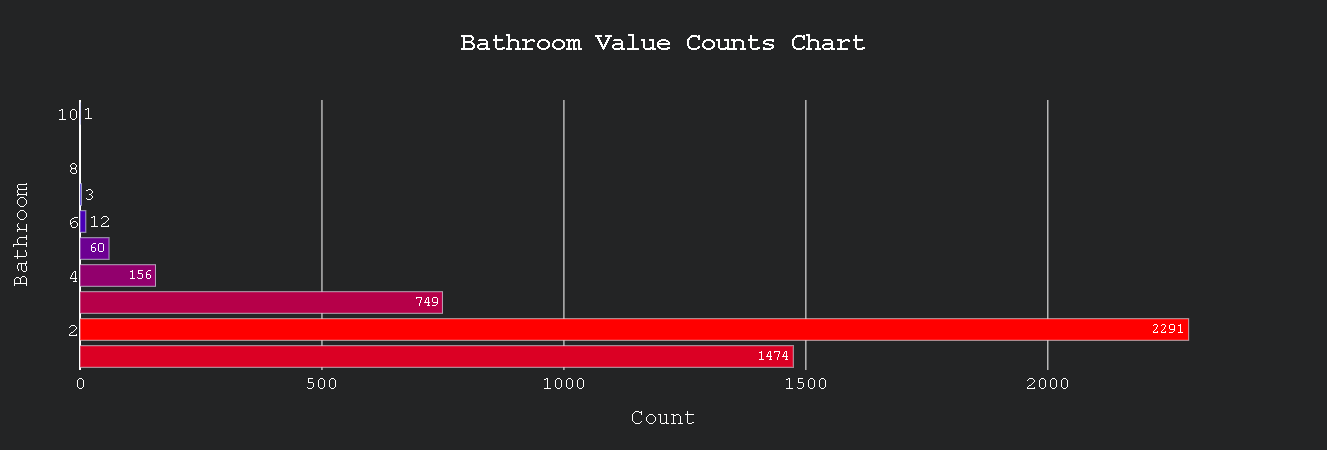

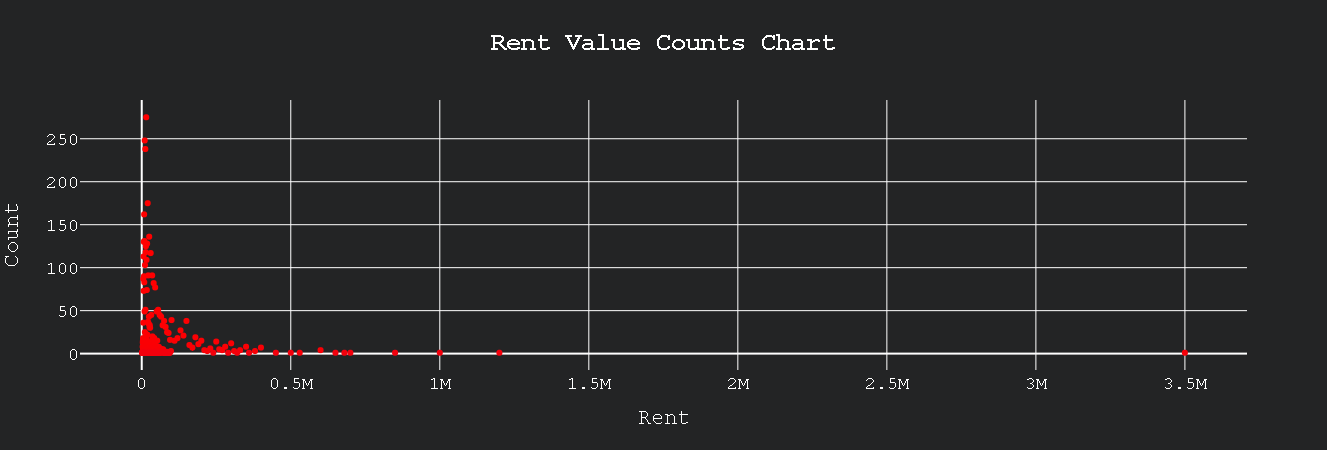

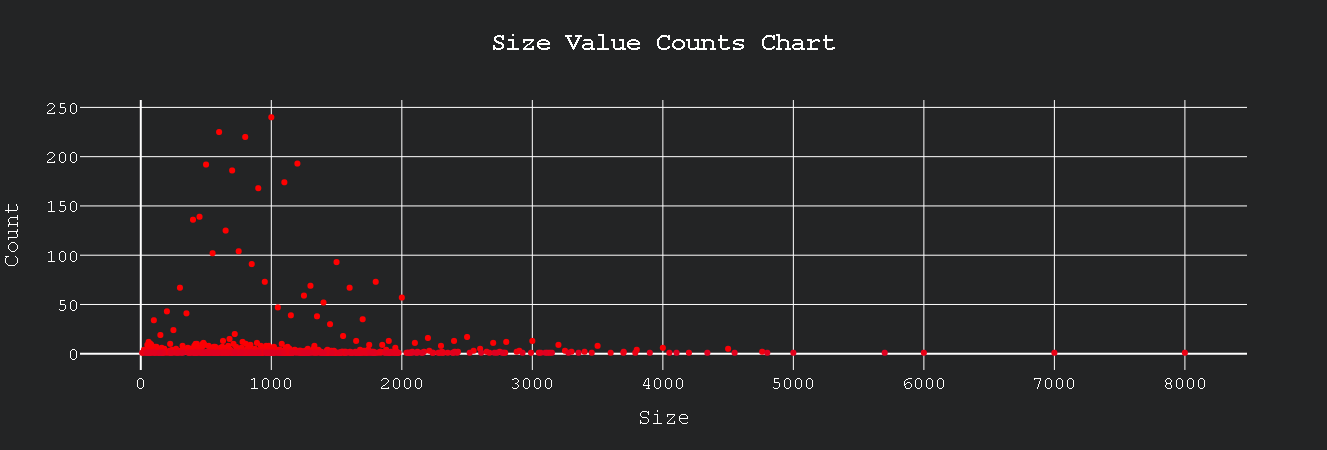

In [7]:
class prep_start_EDA:  
    def shape(df):
        display(html_print(cstr(' SHAPE '.center(60,'-'),'purple')))
        print("Observations: {} \n Features: {} \n Shape Dataset: {}".format(df.shape[0],df.shape[1],df.shape))
    def value_counts(df):
        display(html_print(cstr(' Value Counts '.center(60,'-'),'purple')))
        if date_cols!=[]:
            for i in date_cols:
                colors=n_colors('rgb(255, 0, 0)', 'rgb(0, 0, 255)', df[i].shape[0], colortype='rgb')
                val=df[i].value_counts()
                fig = go.Figure(data=go.Scatter(
                    x=val.index,
                    y=val.iloc[:,],
                    mode='markers',
                    marker=dict(size=np.arange(len(val),0,-1,dtype=int),
                                color=colors)
                ))
                fig.update_layout(title_text='<b>'+df[i].name+' Value Counts Chart'+'</b>',
                              title_x=0.5,
                              paper_bgcolor='#232425',
                              plot_bgcolor='#232425',
                              font=dict(
                                  family="Courier New, monospace",
                                  size=18,
                                  color='white'),
                                  xaxis_title=df[i].name,
                                  yaxis_title='Count')
                fig.show()
                print('\n')
            
            
        if cat_col!=[]:
            for i in cat_col:
                val=df[i].value_counts()
                colors=n_colors('rgb(255, 0, 0)', 'rgb(0, 0, 255)', val.shape[0], colortype='rgb')
                fig1=go.Figure(data=[go.Bar(x=val.iloc[:,],
                                        y=val.index,
                                        marker=dict(color=colors),
                                        name=df[i].name,

                                        text=val.iloc[:,],
                                        textposition='auto',
                                        hoverinfo='text',
                                        orientation='h'
                                       )])
                fig1.update_layout(title_text='<b>'+df[i].name+' Value Counts Chart'+'</b>',
                              title_x=0.5,
                              paper_bgcolor='#232425',
                              plot_bgcolor='#232425',
                              font=dict(
                                  family="Courier New, monospace",
                                  size=18,
                                  color='white'),
                                  xaxis_title='Count',
                                  yaxis_title=df[i].name)
                fig1.show()
                print('\n')
        if num_col!=[]:
            for i in num_col:
                colors=n_colors('rgb(255, 0, 0)', 'rgb(0, 0, 255)', df[i].shape[0], colortype='rgb')
                val=df[i].value_counts()
                fig = go.Figure(data=go.Scatter(
                    x=val.index,
                    y=val.iloc[:,],
                    mode='markers',
                    marker=dict(color=colors)
                ))
                fig.update_layout(title_text='<b>'+df[i].name+' Value Counts Chart'+'</b>',
                              title_x=0.5,
                              paper_bgcolor='#232425',
                              plot_bgcolor='#232425',
                              font=dict(
                                  family="Courier New, monospace",
                                  size=18,
                                  color='white'),
                                  xaxis_title=df[i].name,
                                  yaxis_title='Count')
                fig.show()
                print('\n')
            
            
    def missing_val(df):
        null_df=pd.DataFrame(pd.isnull(df).sum()).sort_values(by=0,ascending=False).astype('int')
        if(any(null_df)==True):
            colors=n_colors('rgb(255, 200, 200)', 'rgb(200, 0, 0)', df.shape[1], colortype='rgb')
            fig1=go.Figure(data=[go.Bar(x=null_df[0],
                                        y=null_df.index,
                                        marker=dict(color='darkred'),
                                        orientation='h',
                                       )])
            fig.update_layout(title_text='<b>Missing Values</b>',
                          title_x=0.5,
                          font=dict(
                              family="Courier New, monospace",
                              size=18,
                              color='RebeccaPurple')
                         )
            fig1.show()
        else:
            display(html_print(cstr(' Missing Values '.center(60,'-'),'purple')))
            print('{}'.format(null_df))
    
        
    def duplicate_val(df):
        dup=df.duplicated().sum()
        display(html_print(cstr(' Duplicated Data Count '.center(60,'-'),'purple')))
        print("{}".format(str(dup)))
    def types_feature(df):
        display(html_print(cstr(' Types Feature '.center(60,'-'),'purple')))
        print("{}".format(df.dtypes))
    def info(df):
        display(html_print(cstr(' INFO '.center(60,'-'),'purple')))
        print("{}".format(df.info()))
    def describe(df):
        desc=df.describe(percentiles=[.01,.05,.1,.25,.5,.75,.90,.99])
        header_val=['<b>'+ col +'</b>' for col in desc]
        header_val.insert(0,'Index / Col')

        val=[desc[col] for col in desc]
        headerColor = 'grey'
        rowEvenColor = 'lightgrey'
        rowOddColor = 'white'
        fig=go.Figure(data=[go.Table(
            header=dict(
                values=header_val,
                line_color='darkslategray',
                fill_color='grey',
                align=['left','center'],
                font=dict(color='white',size=12)
        ),
            cells=dict(
                values=[
                    desc.index,
                    val[0],
                    val[1],
                    val[2],
                    val[3]],
                line_color='darkslategray',
                fill_color=[[rowOddColor,rowEvenColor]*13],
                align = ['left', 'center'],
                font = dict(color = 'darkslategray', size = 11)
            )
        )]
        )
        fig.update_layout(title_text='<b>DESCRIBE</b>',
                          title_x=0.5,
                          font=dict(
                              family="Courier New, monospace",
                              size=18,
                              color='RebeccaPurple')
                         )
        
        fig.show()
    

method_list = [method for method in dir(prep_start_EDA) if method.startswith('__') is False]
print(method_list)

for i in method_list:
    getattr(prep_start_EDA, i)(csv)

## Outlier Dedection and Dropout

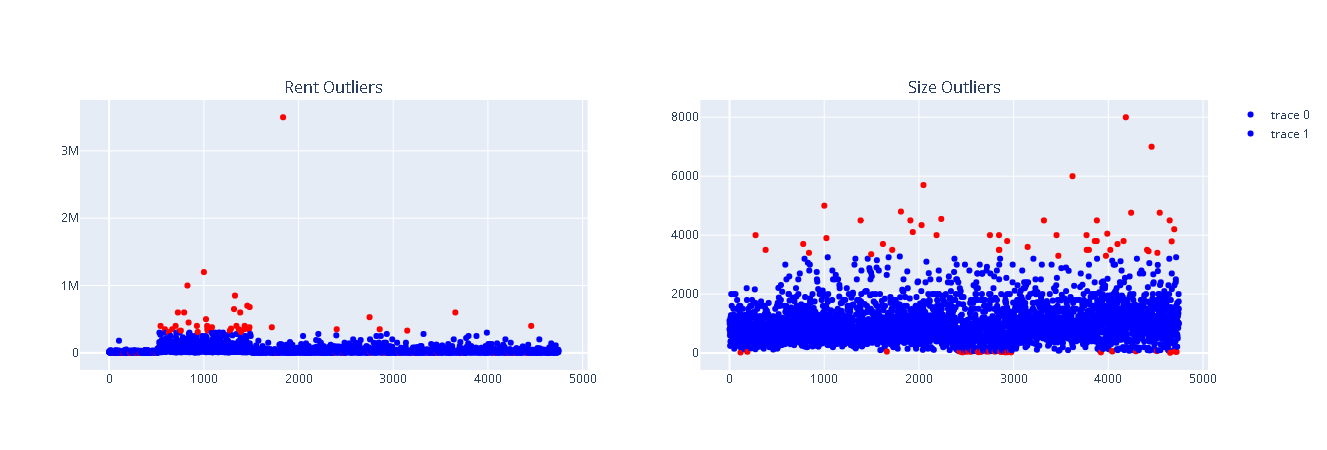

In [8]:
def outliers(df):
    outliers={}
    outliers_titles=[i for i in df.columns]
    col_max=3
    if len(df.columns)<col_max: col_max=len(df.columns)
    row_max=int(len(df.columns)/col_max)+(len(df.columns)%col_max)
    fig = make_subplots(rows=row_max, cols=col_max,subplot_titles=[i+' Outliers' for i in df.columns])
    col_n=0
    row_n=1
    
    for num,col in enumerate(df):
        from scipy.stats import iqr
        iqr=iqr(df[col])
        lower=np.quantile(df[col],0.01)
        upper=np.quantile(df[col],0.99)
        #filt=((df[col]<lower_threshold) | (df[col]>upper_threshold))
        outliers[outliers_titles[num]]=df[((df[col] < lower) |(df[col] > upper))]
        def setColor(y,lower,upper):    
            if (y>upper) | (y<lower):
                return "red"
            else:
                return "blue"
        col_n=col_n+1
        if col_n==col_max+1:
            col_n=1
            row_n=row_n+1
        if row_n==row_max+1:
            row_n=1
        fig.add_trace(go.Scatter(
                        y=df[col],
                        mode='markers',
                        marker=dict(color=[setColor(y,lower,upper) for y in df[col]])
                    ),
                    row=row_n,col=col_n    
                          )
    fig.show()
    return outliers
out=outliers(csv[num_col])



In [9]:
def drop_outliers(df,drop_index):
    for i in out.values():
        for k in i.index:
            try:
                df.drop(k,axis=0,inplace=True)
            except KeyError:
                continue
    df.reset_index(drop=True,inplace=True)
    print('Completed..')
    return df
nonout_csv=drop_outliers(csv,out)


Completed..


## Transformation & Corelation 

The highest correlation was achieved with the pre-correlation Target variable log transformation method.(box-cox,sqrt,cubic)

In [10]:
csv_log=nonout_csv.copy()
encoder=LabelEncoder()
non_num=cat_col+date_cols+cat_but_num
for i in non_num:
    csv_log[i]=encoder.fit_transform(csv_log[i])
log=['Rent','Size']
sqrt=cat_but_num
csv_log[log[0]]=np.log10(csv_log[log[0]]) #Rent log10
#csv_log[log[1]]=np.sqrt(csv_log[log[1]]) #Size sqrt/cubic np.cbrt(data)

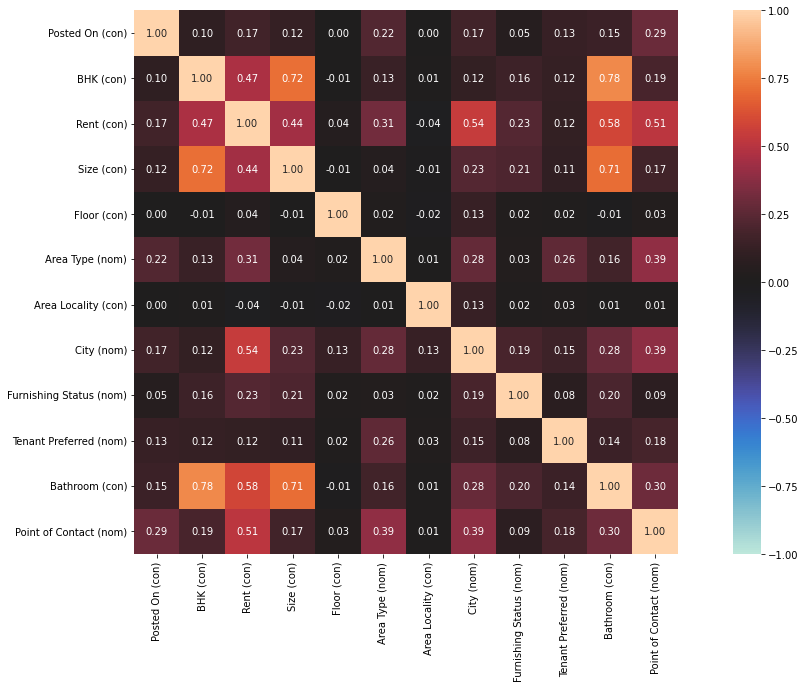

{'corr':                          Posted On (con)  BHK (con)  Rent (con)  Size (con)  \
 Posted On (con)                 1.000000   0.100342    0.168560    0.122216   
 BHK (con)                       0.100342   1.000000    0.467177    0.715388   
 Rent (con)                      0.168560   0.467177    1.000000    0.441426   
 Size (con)                      0.122216   0.715388    0.441426    1.000000   
 Floor (con)                     0.002094  -0.006534    0.039550   -0.006642   
 Area Type (nom)                 0.221461   0.132907    0.313342    0.044565   
 Area Locality (con)             0.000986   0.012570   -0.035288   -0.012378   
 City (nom)                      0.168334   0.116051    0.539996    0.230191   
 Furnishing Status (nom)         0.049416   0.155682    0.233288    0.208136   
 Tenant Preferred (nom)          0.128903   0.117386    0.116270    0.108888   
 Bathroom (con)                  0.146329   0.781359    0.584899    0.705183   
 Point of Contact (nom)         

In [20]:
from dython import nominal
nominal.associations(nonout_csv,figsize=(20,10),num_num_assoc='pearson',mark_columns=True)


### Distribution and trend line of data after Log Transformation (Before / After)

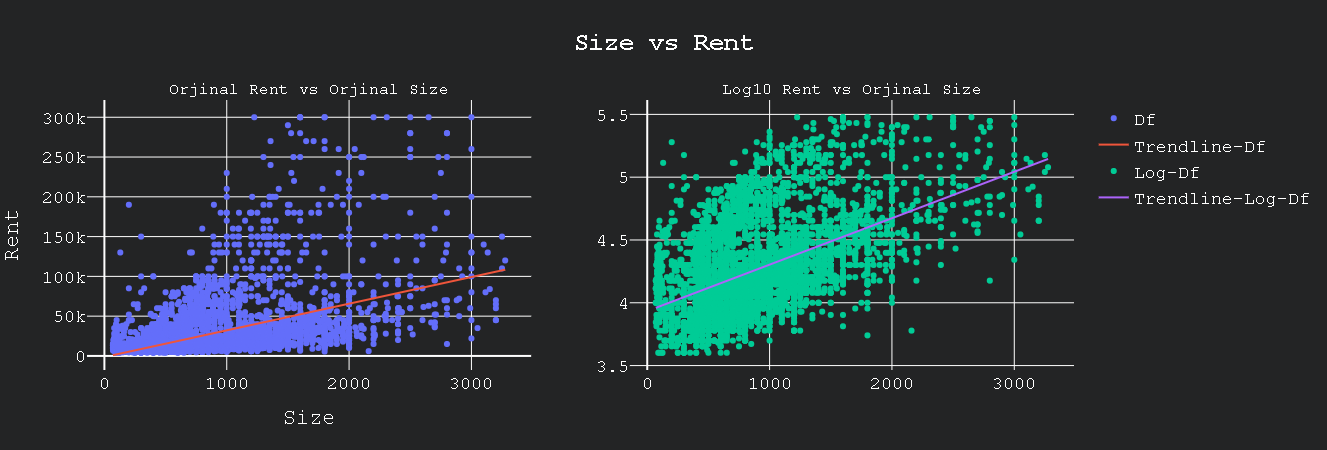

In [14]:
def num_comp(old_df,df,x,y):
    
    model = LinearRegression()
    x_old=old_df[x].values.reshape(-1,1)
    y_old=old_df[y].values.reshape(-1,1)
    model.fit(x_old,y_old)
    xold_range=np.linspace(x_old.min(),x_old.max(),20)
    yold_range=model.predict(xold_range.reshape(-1,1))
    #model.fit(X, df.tip)
    fig = make_subplots(rows=1, cols=2,subplot_titles=('Orjinal Rent vs Orjinal Size',  'Log10 Rent vs Orjinal Size'))
    fig.add_trace(
        go.Scatter(x=old_df[x], y=old_df[y],mode='markers',name='Df'),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=xold_range, y=yold_range.reshape(1,-1)[0],name='Trendline-Df'),
        row=1,col=1
    )

    fig.add_trace(
        go.Scatter(x=df[x], y=df[y],mode='markers',name='Log-Df'),
        row=1, col=2
    )
    x_log=df[x].values.reshape(-1,1)
    y_log=df[y].values.reshape(-1,1)
    model.fit(x_log,y_log)
    xlog_range=np.linspace(x_log.min(),x_log.max(),20)
    ylog_range=model.predict(xlog_range.reshape(-1,1))
    fig.add_trace(
        go.Scatter(x=xlog_range,y=ylog_range.reshape(1,-1)[0],name='Trendline-Log-Df'),
        row=1,col=2
    )

    fig.update_layout(title_text='<b>'+df[x].name+' vs '+df[y].name+'</b>',
                  title_x=0.5,
                  paper_bgcolor='#232425',
                  plot_bgcolor='#232425',
                  font=dict(
                      family="Courier New, monospace",
                      size=18,
                      color='white'),
                      xaxis_title=df[x].name,
                      yaxis_title=df[y].name)
    fig.show()
    
num_comp(csv,csv_log,'Size','Rent')

## 

## Encoding and Train/Test Split Data

Before Hyperparam optimization, making a prediction. Take a result.

In [15]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler,StandardScaler,LabelEncoder
def date_col_sep(df):
    df['month'] = df['Posted On'].dt.month
    df['day'] = df['Posted On'].dt.day
    df['day of week'] = df['Posted On'].dt.day_of_week
    df['quarter'] = df['Posted On'].dt.quarter
    df.drop(['Posted On'],axis=1,inplace=True)
    print('Completed..')
    return df
def encode(df):
    for i in df[date_cols+cat_but_num]:
        encoder=LabelEncoder()
        df[i]=encoder.fit_transform(df[i])
    for k in df[cat_col]:
        ohe_df=pd.get_dummies(df[k],drop_first=True)
        df=pd.concat([df,ohe_df],axis=1)
    df.drop(cat_col,axis=1,inplace=True)
    return df

def tt_split(df,random_state=8,test_size=0.25):
    scaler=StandardScaler()
    X=df.drop('Rent',axis=1)
    #X['Size']=np.sqrt(X['Size'])
    y=np.log10(df['Rent'])
    #y=df['Rent']

    X=scaler.fit_transform(X)
    
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=test_size,random_state=random_state)
    return X_train,X_test,y_train,y_test

X_train,X_test,y_train,y_test=tt_split(encode(nonout_csv),8,0.23)

def predict(obj,X_train,y_train,y_test):
    from sklearn.metrics import mean_squared_error
    reg=obj
    reg.fit(X_train,y_train)
    predictions = reg.predict(X_test)
    rmsle=np.sqrt(mean_squared_error(y_test,predictions))
    return rmsle,predictions
print(predict(xgb.XGBRegressor(booster='gblinear'),X_train,y_train,y_test))
rmse,pred=predict(xgb.XGBRegressor(booster='gblinear'),X_train,y_train,y_test)



def_pred=pow(10,pred)



/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



(178.18548873379356, array([4.9600763, 4.5671415, 4.0896044, ..., 3.845084 , 4.5996046,
       4.121772 ], dtype=float32))


In [16]:
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import r2_score
r2_score(pow(10,y_test),def_pred)

0.743974566655865

## Hyperparameter Optimization With Optuna

In [21]:
import re

dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test, label = y_test)
def get_model_rmse(params):
    model = xgb.train(params, dtrain, num_boost_round=1000, evals=[(dtest, 'eval')], early_stopping_rounds=10, verbose_eval=0)
    results = model.eval(dtest)
    rmse = np.float(re.search(r'[\d.]+$', results).group(0))
    return rmse
def objective(trial):
    boosting_list=trial.suggest_categorical('boosting', ['gbtree', 'gblinear'])
    tree_method = trial.suggest_categorical('tree_method',['exact','approx','hist'])
    learning_rate = trial.suggest_loguniform('learning_rate', 0.005, 0.5)
    max_depth = trial.suggest_int('max_depth', 2, 25)
    sampling_method =trial.suggest_categorical('sampling_method',['uniform'])
    min_split_loss=trial.suggest_int('min_split_loss',0,12)
    min_child_weight=trial.suggest_int('min_child_weight',0,5)
    metric_list=trial.suggest_categorical('eval_metric', ['rmse'])
    objective_list=trial.suggest_categorical('objective', ['reg:linear', 'reg:gamma', 'reg:tweedie'])
    colsample_bytree=trial.suggest_discrete_uniform('colsample_bytree', 0.1, 1, 0.01)
    colsample_bynode=trial.suggest_discrete_uniform('colsample_bynode', 0.1, 1, 0.01)
    colsample_bylevel=trial.suggest_discrete_uniform('colsample_bylevel', 0.1, 1, 0.01)
    subsample=trial.suggest_discrete_uniform('subsample', 0.5, 1, 0.05)
    gamma=trial.suggest_int('gamma', 0, 5)
    l1_reg = trial.suggest_loguniform('l1_reg', 0.00001, 10.0)
    l2_reg = trial.suggest_loguniform('l2_reg', 0.00001, 10.0)
    
    params = {'boosting':boosting_list,'tree_method':tree_method,'learning_rate': learning_rate, 'max_depth': max_depth,'sampling_method':sampling_method,'min_split_loss':min_split_loss,
              'min_child_weight':min_child_weight,'eval_metric':metric_list,'objective':objective_list,'colsample_bytree':colsample_bytree,
              'colsample_bynode':colsample_bynode,'colsample_bylevel':colsample_bylevel,'subsample':subsample,'gamma':gamma,'alpha': l1_reg, 'lambda': l2_reg}
    
    return get_model_rmse(params)
study = optuna.create_study()
optuna.logging.set_verbosity(optuna.logging.DEBUG)
study.optimize(objective, n_trials=250, show_progress_bar=True)

[I 2022-11-05 08:03:18,012] A new study created in memory with name: no-name-432a632b-c6d8-4c5f-9f6d-719884cb7ce9
/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/250 [00:00<?, ?it/s]

[08:03:18] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:18] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:23,398] Trial 0 finished with value: 0.2321761418713965 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'learning_rate': 0.008881857047085072, 'max_depth': 2, 'sampling_method': 'uniform', 'min_split_loss': 12, 'min_child_weight': 4, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.49, 'colsample_bynode': 0.5700000000000001, 'colsample_bylevel': 0.92, 'subsample': 0.75, 'gamma': 2, 'l1_reg': 0.009824095949029424, 'l2_reg': 9.019479069009467}. Best is trial 0 with value: 0.2321761418713965.
[08:03:23] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:25,742] Trial 1 finished with value: 0.33959301646528245 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'learning_rate': 0.03187882788819562, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 4, 'min_child_weight': 1, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.49, 'colsample_bynode': 0.16, 'colsample_bylevel': 0.41000000000000003, 'subsample': 0.8500000000000001, 'gamma': 2, 'l1_reg': 0.0030676219192197485, 'l2_reg': 0.13054579089283833}. Best is trial 0 with value: 0.2321761418713965.
[08:03:25] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:27,722] Trial 2 finished with value: 0.2257635831191266 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'learning_rate': 0.040961227855617906, 'max_depth': 9, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 1, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.36, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.93, 'subsample': 0.6, 'gamma': 4, 'l1_reg': 0.0033798758158115586, 'l2_reg': 0.005448449525390827}. Best is trial 2 with value: 0.2257635831191266.
[08:03:27] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:28,771] Trial 3 finished with value: 0.3121112276670284 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'learning_rate': 0.06007041892224105, 'max_depth': 2, 'sampling_method': 'uniform', 'min_split_loss': 5, 'min_child_weight': 4, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.55, 'colsample_bynode': 0.11, 'colsample_bylevel': 0.88, 'subsample': 0.65, 'gamma': 0, 'l1_reg': 1.0685157441256177, 'l2_reg': 0.006619820287881264}. Best is trial 2 with value: 0.2257635831191266.
[08:03:28] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:29,285] Trial 4 finished with value: 0.33611166429542627 and parameters: {'boosting': 'gblinear', 'tree_method': 'approx', 'learning_rate': 0.1786290527344924, 'max_depth': 3, 'sampling_method': 'uniform', 'min_split_loss': 9, 'min_child_weight': 5, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.45999999999999996, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.31, 'subsample': 0.8500000000000001, 'gamma': 3, 'l1_reg': 2.729701720251539e-05, 'l2_reg': 0.0032996491932277333}. Best is trial 2 with value: 0.2257635831191266.
[08:03:29] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:29] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:30,369] Trial 5 finished with value: 0.2153683500790091 and parameters: {'boosting': 'gblinear', 'tree_method': 'approx', 'learning_rate': 0.062075909821518664, 'max_depth': 20, 'sampling_method': 'uniform', 'min_split_loss': 4, 'min_child_weight': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.27, 'colsample_bynode': 0.42000000000000004, 'colsample_bylevel': 0.27, 'subsample': 1.0, 'gamma': 3, 'l1_reg': 0.4695408813763372, 'l2_reg': 4.3807317608553245}. Best is trial 5 with value: 0.2153683500790091.
[08:03:30] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:30,824] Trial 6 finished with value: 0.21770435064662094 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'learning_rate': 0.13507830638690388, 'max_depth': 22, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 5, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.49, 'colsample_bynode': 0.52, 'colsample_bylevel': 0.26, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.0025296249344041815, 'l2_reg': 0.55216329394814}. Best is trial 5 with value: 0.2153683500790091.
[08:03:30] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:30] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:32,770] Trial 7 finished with value: 0.19807193735286702 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'learning_rate': 0.04012598957182827, 'max_depth': 7, 'sampling_method': 'uniform', 'min_split_loss': 4, 'min_child_weight': 4, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.94, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.79, 'subsample': 0.7, 'gamma': 3, 'l1_reg': 6.0125135127322524e-05, 'l2_reg': 0.00068380075062189}. Best is trial 7 with value: 0.19807193735286702.
[08:03:32] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:40,391] Trial 8 finished with value: 0.3890169848232319 and parameters: {'boosting': 'gblinear', 'tree_method': 'approx', 'learning_rate': 0.009472947030734421, 'max_depth': 7, 'sampling_method': 'uniform', 'min_split_loss': 11, 'min_child_weight': 1, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.88, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.38, 'subsample': 0.65, 'gamma': 3, 'l1_reg': 0.0203880328678453, 'l2_reg': 6.511344953813365}. Best is trial 7 with value: 0.19807193735286702.
[08:03:40] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:40] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find a

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:40,694] Trial 9 finished with value: 0.2327218818390741 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'learning_rate': 0.3241414169198171, 'max_depth': 15, 'sampling_method': 'uniform', 'min_split_loss': 10, 'min_child_weight': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.71, 'colsample_bynode': 0.37, 'colsample_bylevel': 0.64, 'subsample': 0.5, 'gamma': 3, 'l1_reg': 5.099543053997943e-05, 'l2_reg': 4.5328480603098324e-05}. Best is trial 7 with value: 0.19807193735286702.
[08:03:40] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:40] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you f

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:42,954] Trial 10 finished with value: 0.2212863494747672 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.0185853404824073, 'max_depth': 14, 'sampling_method': 'uniform', 'min_split_loss': 7, 'min_child_weight': 3, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.97, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.6799999999999999, 'subsample': 0.5, 'gamma': 5, 'l1_reg': 0.00018886627983065012, 'l2_reg': 7.686339662540401e-05}. Best is trial 7 with value: 0.19807193735286702.
[08:03:42] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:42] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an is

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:43,903] Trial 11 finished with value: 0.22439856736753241 and parameters: {'boosting': 'gblinear', 'tree_method': 'hist', 'learning_rate': 0.08461987108032475, 'max_depth': 21, 'sampling_method': 'uniform', 'min_split_loss': 3, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.14, 'colsample_bynode': 0.37, 'colsample_bylevel': 0.13, 'subsample': 1.0, 'gamma': 4, 'l1_reg': 8.078154197095845, 'l2_reg': 0.0004778882327095425}. Best is trial 7 with value: 0.19807193735286702.
[08:03:43] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:43] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fin

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:46,911] Trial 12 finished with value: 0.2256306847751241 and parameters: {'boosting': 'gblinear', 'tree_method': 'approx', 'learning_rate': 0.02158366033297965, 'max_depth': 25, 'sampling_method': 'uniform', 'min_split_loss': 7, 'min_child_weight': 3, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.13, 'colsample_bynode': 0.5, 'colsample_bylevel': 0.73, 'subsample': 1.0, 'gamma': 1, 'l1_reg': 0.16115131591947468, 'l2_reg': 0.11747449518870325}. Best is trial 7 with value: 0.19807193735286702.
[08:03:46] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:46] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fin

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:47,702] Trial 13 finished with value: 0.19351103911682715 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'learning_rate': 0.10615978932330634, 'max_depth': 18, 'sampling_method': 'uniform', 'min_split_loss': 3, 'min_child_weight': 2, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.28, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.5, 'subsample': 0.9, 'gamma': 4, 'l1_reg': 0.11095935462428953, 'l2_reg': 0.0004850138575955833}. Best is trial 13 with value: 0.19351103911682715.
[08:03:47] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:47] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fi

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:48,251] Trial 14 finished with value: 0.18307242136901802 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.29656862821327956, 'max_depth': 16, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 2, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.74, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.53, 'subsample': 0.8500000000000001, 'gamma': 5, 'l1_reg': 0.0005136946998752197, 'l2_reg': 0.0006052792898236798}. Best is trial 14 with value: 0.18307242136901802.
[08:03:48] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:48] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:48,565] Trial 15 finished with value: 0.18110527649556235 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.40239651989600067, 'max_depth': 17, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 2, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.7, 'colsample_bynode': 0.97, 'colsample_bylevel': 0.53, 'subsample': 0.9, 'gamma': 5, 'l1_reg': 0.07177765591726358, 'l2_reg': 1.070918094292107e-05}. Best is trial 15 with value: 0.18110527649556235.
[08:03:48] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:48,938] Trial 16 finished with value: 0.17708939557932726 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.43877156889441044, 'max_depth': 17, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 2, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.74, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.5700000000000001, 'subsample': 0.9, 'gamma': 5, 'l1_reg': 0.0004055986337615111, 'l2_reg': 1.4743262438504164e-05}. Best is trial 16 with value: 0.17708939557932726.
[08:03:48] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:49,256] Trial 17 finished with value: 0.1742980769122847 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.3520676207340822, 'max_depth': 11, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 2, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.6799999999999999, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.63, 'subsample': 0.9, 'gamma': 5, 'l1_reg': 0.0003843144209950109, 'l2_reg': 1.4267387688948553e-05}. Best is trial 17 with value: 0.1742980769122847.
[08:03:49] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:49,621] Trial 18 finished with value: 0.27384748611805276 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.21828868662520623, 'max_depth': 11, 'sampling_method': 'uniform', 'min_split_loss': 2, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.82, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.63, 'subsample': 0.9, 'gamma': 5, 'l1_reg': 1.0402509586410771e-05, 'l2_reg': 1.0272354439824178e-05}. Best is trial 17 with value: 0.1742980769122847.
[08:03:49] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:49,843] Trial 19 finished with value: 0.27078393644622667 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.47885206802045177, 'max_depth': 12, 'sampling_method': 'uniform', 'min_split_loss': 2, 'min_child_weight': 3, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.59, 'colsample_bynode': 0.86, 'colsample_bylevel': 0.8099999999999999, 'subsample': 0.95, 'gamma': 4, 'l1_reg': 0.0003208389036736925, 'l2_reg': 7.52719003095206e-05}. Best is trial 17 with value: 0.1742980769122847.
[08:03:49] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:50,338] Trial 20 finished with value: 0.17150699182959112 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.2159460960041718, 'max_depth': 12, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 2, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.63, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.45000000000000007, 'subsample': 0.8, 'gamma': 5, 'l1_reg': 0.0008256817530696504, 'l2_reg': 3.706954065669064e-05}. Best is trial 20 with value: 0.17150699182959112.
[08:03:50] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:50,847] Trial 21 finished with value: 0.16829354190237988 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.20637447025341749, 'max_depth': 12, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 2, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.63, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.45000000000000007, 'subsample': 0.8, 'gamma': 5, 'l1_reg': 0.001043484699708049, 'l2_reg': 3.183759913894102e-05}. Best is trial 21 with value: 0.16829354190237988.
[08:03:50] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:51,215] Trial 22 finished with value: 0.252791909163535 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.2117895546604085, 'max_depth': 11, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 2, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.61, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.43000000000000005, 'subsample': 0.8, 'gamma': 4, 'l1_reg': 0.001118087826101263, 'l2_reg': 9.303963299480466e-05}. Best is trial 21 with value: 0.16829354190237988.
[08:03:51] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:51,669] Trial 23 finished with value: 0.2998674995136004 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.15480237792712373, 'max_depth': 13, 'sampling_method': 'uniform', 'min_split_loss': 2, 'min_child_weight': 3, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.64, 'colsample_bynode': 0.25, 'colsample_bylevel': 0.48, 'subsample': 0.8, 'gamma': 5, 'l1_reg': 0.013658992143747266, 'l2_reg': 3.731819607007426e-05}. Best is trial 21 with value: 0.16829354190237988.
[08:03:51] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:51,990] Trial 24 finished with value: 0.17663697533540415 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.2534327883974849, 'max_depth': 10, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 2, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.82, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.32, 'subsample': 0.8, 'gamma': 4, 'l1_reg': 0.0010023308173063782, 'l2_reg': 0.00013757259887291952}. Best is trial 21 with value: 0.16829354190237988.
[08:03:52] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:52,702] Trial 25 finished with value: 0.2602609403357781 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.09819773284430622, 'max_depth': 5, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 3, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.64, 'colsample_bynode': 0.8099999999999999, 'colsample_bylevel': 0.13, 'subsample': 0.75, 'gamma': 5, 'l1_reg': 0.00013353555992323828, 'l2_reg': 0.00025327460625745044}. Best is trial 21 with value: 0.16829354190237988.
[08:03:52] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:53,015] Trial 26 finished with value: 0.33731867976960167 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.272233308647873, 'max_depth': 14, 'sampling_method': 'uniform', 'min_split_loss': 6, 'min_child_weight': 1, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.8, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.62, 'subsample': 0.95, 'gamma': 5, 'l1_reg': 0.006212356083087257, 'l2_reg': 3.471014075843826e-05}. Best is trial 21 with value: 0.16829354190237988.
[08:03:53] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:53,566] Trial 27 finished with value: 0.32650386768514184 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.13622502131292608, 'max_depth': 12, 'sampling_method': 'uniform', 'min_split_loss': 3, 'min_child_weight': 2, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.42000000000000004, 'colsample_bynode': 0.41000000000000003, 'colsample_bylevel': 0.2, 'subsample': 0.7, 'gamma': 4, 'l1_reg': 0.000782063902849831, 'l2_reg': 0.0023628398825296174}. Best is trial 21 with value: 0.16829354190237988.
[08:03:53] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:53,869] Trial 28 finished with value: 0.27399639866847075 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.3293789726411094, 'max_depth': 5, 'sampling_method': 'uniform', 'min_split_loss': 2, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.66, 'colsample_bynode': 0.47, 'colsample_bylevel': 0.58, 'subsample': 0.8, 'gamma': 1, 'l1_reg': 0.031614535211877744, 'l2_reg': 0.03355372988067816}. Best is trial 21 with value: 0.16829354190237988.
[08:03:53] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:54,845] Trial 29 finished with value: 0.16673524113866614 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.08241739816654578, 'max_depth': 9, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 4, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.56, 'colsample_bynode': 0.5700000000000001, 'colsample_bylevel': 0.47, 'subsample': 0.7, 'gamma': 5, 'l1_reg': 0.00012171877692416829, 'l2_reg': 0.0017013095621845004}. Best is trial 29 with value: 0.16673524113866614.
[08:03:54] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:55,719] Trial 30 finished with value: 0.38895735815012145 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.07915715366785196, 'max_depth': 9, 'sampling_method': 'uniform', 'min_split_loss': 12, 'min_child_weight': 4, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.54, 'colsample_bynode': 0.5700000000000001, 'colsample_bylevel': 0.45000000000000007, 'subsample': 0.7, 'gamma': 2, 'l1_reg': 8.786382573926384e-05, 'l2_reg': 0.0012403439735473236}. Best is trial 29 with value: 0.16673524113866614.
[08:03:55] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:56,193] Trial 31 finished with value: 0.1715091163021351 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.18385431034234664, 'max_depth': 10, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 3, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.55, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.33999999999999997, 'subsample': 0.75, 'gamma': 5, 'l1_reg': 0.00141662782416238, 'l2_reg': 0.0002017109772655043}. Best is trial 29 with value: 0.16673524113866614.
[08:03:56] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:56,931] Trial 32 finished with value: 0.2546474978083094 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.12334306988130637, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 4, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.54, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.39, 'subsample': 0.75, 'gamma': 5, 'l1_reg': 0.00215645024834629, 'l2_reg': 0.019200535696679046}. Best is trial 29 with value: 0.16673524113866614.
[08:03:56] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:58,285] Trial 33 finished with value: 0.17376723092571333 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.1955884415551147, 'max_depth': 6, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 3, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.39, 'colsample_bynode': 0.55, 'colsample_bylevel': 0.35, 'subsample': 0.65, 'gamma': 4, 'l1_reg': 0.007490291173583987, 'l2_reg': 0.00018250191590509654}. Best is trial 29 with value: 0.16673524113866614.
[08:03:58] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:03:59,184] Trial 34 finished with value: 0.2687091048973952 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.06839239947880232, 'max_depth': 9, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 4, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.48, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.44000000000000006, 'subsample': 0.55, 'gamma': 5, 'l1_reg': 2.0284478574850496e-05, 'l2_reg': 0.0002571379188531236}. Best is trial 29 with value: 0.16673524113866614.
[08:03:59] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:04:04,615] Trial 35 finished with value: 0.2860321877512266 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.005367358828882284, 'max_depth': 13, 'sampling_method': 'uniform', 'min_split_loss': 2, 'min_child_weight': 5, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.59, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.21000000000000002, 'subsample': 0.7, 'gamma': 4, 'l1_reg': 0.0018591237911608834, 'l2_reg': 0.001290784088987931}. Best is trial 29 with value: 0.16673524113866614.
[08:04:04] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:04:06,280] Trial 36 finished with value: 0.16433535361819196 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'learning_rate': 0.05101509884956841, 'max_depth': 10, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 3, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.54, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.98, 'subsample': 0.6, 'gamma': 5, 'l1_reg': 0.004466514464654466, 'l2_reg': 2.495284954910662e-05}. Best is trial 36 with value: 0.16433535361819196.
[08:04:06] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:04:07,661] Trial 37 finished with value: 0.30928246992282343 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'learning_rate': 0.051619523077431465, 'max_depth': 15, 'sampling_method': 'uniform', 'min_split_loss': 5, 'min_child_weight': 4, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.33, 'colsample_bynode': 0.49, 'colsample_bylevel': 0.74, 'subsample': 0.6, 'gamma': 4, 'l1_reg': 0.00388943194297116, 'l2_reg': 2.6725382360926405e-05}. Best is trial 36 with value: 0.16433535361819196.
[08:04:07] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:04:11,316] Trial 38 finished with value: 0.34001310446082095 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'learning_rate': 0.02494235354440986, 'max_depth': 4, 'sampling_method': 'uniform', 'min_split_loss': 3, 'min_child_weight': 5, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.45000000000000007, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.96, 'subsample': 0.6, 'gamma': 5, 'l1_reg': 0.0001679732778085952, 'l2_reg': 0.006423685314824499}. Best is trial 36 with value: 0.16433535361819196.
[08:04:11] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:04:13,509] Trial 39 finished with value: 0.2629606788011996 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'learning_rate': 0.036308013711343706, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 1, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.51, 'colsample_bynode': 0.28, 'colsample_bylevel': 0.49, 'subsample': 0.55, 'gamma': 2, 'l1_reg': 0.0050034016955575735, 'l2_reg': 1.6771226034153344}. Best is trial 36 with value: 0.16433535361819196.
[08:04:13] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:04:15,435] Trial 40 finished with value: 0.33116941282324047 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'learning_rate': 0.05112619353350096, 'max_depth': 12, 'sampling_method': 'uniform', 'min_split_loss': 8, 'min_child_weight': 3, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.6, 'colsample_bynode': 0.54, 'colsample_bylevel': 0.88, 'subsample': 0.8500000000000001, 'gamma': 1, 'l1_reg': 2.657074329183623e-05, 'l2_reg': 2.7639501198852787e-05}. Best is trial 36 with value: 0.16433535361819196.
[08:04:15] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:04:16,107] Trial 41 finished with value: 0.1670988021006996 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'learning_rate': 0.16337518744043505, 'max_depth': 10, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 3, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.55, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.38, 'subsample': 0.65, 'gamma': 5, 'l1_reg': 0.0013469826083872742, 'l2_reg': 7.609574421894454e-05}. Best is trial 36 with value: 0.16433535361819196.
[08:04:16] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:04:16,620] Trial 42 finished with value: 0.2468583093450376 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'learning_rate': 0.15558798423018946, 'max_depth': 10, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 3, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.44000000000000006, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.38, 'subsample': 0.65, 'gamma': 5, 'l1_reg': 0.0007294396688451573, 'l2_reg': 7.161831698980058e-05}. Best is trial 36 with value: 0.16433535361819196.
[08:04:16] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:04:17,970] Trial 43 finished with value: 0.1720816671912704 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'learning_rate': 0.11065886979405808, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 4, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.51, 'colsample_bynode': 0.45000000000000007, 'colsample_bylevel': 0.27, 'subsample': 0.65, 'gamma': 5, 'l1_reg': 0.011299316476264335, 'l2_reg': 2.068884423226754e-05}. Best is trial 36 with value: 0.16433535361819196.
[08:04:18] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:04:19,038] Trial 44 finished with value: 0.2580967528921439 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'learning_rate': 0.08468256805714418, 'max_depth': 7, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 2, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.55, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.45999999999999996, 'subsample': 0.55, 'gamma': 4, 'l1_reg': 0.0002894573460679165, 'l2_reg': 0.00010804224450106915}. Best is trial 36 with value: 0.16433535361819196.
[08:04:19] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:04:21,157] Trial 45 finished with value: 0.3584845482079598 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'learning_rate': 0.028666316727627556, 'max_depth': 2, 'sampling_method': 'uniform', 'min_split_loss': 4, 'min_child_weight': 3, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.74, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.38, 'subsample': 0.6, 'gamma': 3, 'l1_reg': 0.0026147699102948892, 'l2_reg': 5.6135302041628854e-05}. Best is trial 36 with value: 0.16433535361819196.
[08:04:21] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:04:26,363] Trial 46 finished with value: 0.2980449871961681 and parameters: {'boosting': 'gblinear', 'tree_method': 'approx', 'learning_rate': 0.01383798950101692, 'max_depth': 10, 'sampling_method': 'uniform', 'min_split_loss': 2, 'min_child_weight': 4, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.37, 'colsample_bynode': 0.52, 'colsample_bylevel': 0.42000000000000004, 'subsample': 0.7, 'gamma': 5, 'l1_reg': 6.41782505477321e-05, 'l2_reg': 0.08492569337855878}. Best is trial 36 with value: 0.16433535361819196.
[08:04:26] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:04:28,888] Trial 47 finished with value: 0.17054128577749272 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'learning_rate': 0.058083320853760306, 'max_depth': 14, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 1, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.63, 'colsample_bynode': 0.79, 'colsample_bylevel': 1.0, 'subsample': 0.8, 'gamma': 4, 'l1_reg': 0.0001571179158105368, 'l2_reg': 0.00035265622498740297}. Best is trial 36 with value: 0.16433535361819196.
[08:04:28] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:04:33,228] Trial 48 finished with value: 0.22027533748399927 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'learning_rate': 0.042504286205565324, 'max_depth': 15, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 1, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.78, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9, 'subsample': 0.8500000000000001, 'gamma': 4, 'l1_reg': 9.826144421896451e-05, 'l2_reg': 0.001193802587174331}. Best is trial 36 with value: 0.16433535361819196.
[08:04:33] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:04:35,320] Trial 49 finished with value: 0.16924678813173474 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'learning_rate': 0.0707596188625754, 'max_depth': 19, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 1, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.69, 'colsample_bynode': 0.56, 'colsample_bylevel': 1.0, 'subsample': 0.65, 'gamma': 4, 'l1_reg': 0.00021838183916834367, 'l2_reg': 0.00038522923408183953}. Best is trial 36 with value: 0.16433535361819196.
[08:04:35] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:04:36,972] Trial 50 finished with value: 0.35639736554035883 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'learning_rate': 0.07387675991820826, 'max_depth': 25, 'sampling_method': 'uniform', 'min_split_loss': 10, 'min_child_weight': 5, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.86, 'colsample_bynode': 0.43000000000000005, 'colsample_bylevel': 0.85, 'subsample': 0.65, 'gamma': 3, 'l1_reg': 4.464480246608457e-05, 'l2_reg': 0.013501736823948094}. Best is trial 36 with value: 0.16433535361819196.
[08:04:37] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:04:39,324] Trial 51 finished with value: 0.1680545050053433 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'learning_rate': 0.05721968900326405, 'max_depth': 19, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 1, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.69, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.99, 'subsample': 0.6, 'gamma': 4, 'l1_reg': 0.00018288003426153806, 'l2_reg': 0.003259023891564387}. Best is trial 36 with value: 0.16433535361819196.
[08:04:39] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:04:41,691] Trial 52 finished with value: 0.17537565693665202 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'learning_rate': 0.09169873013484245, 'max_depth': 19, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.67, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.96, 'subsample': 0.6, 'gamma': 3, 'l1_reg': 0.0003354954046082769, 'l2_reg': 0.0025047472026627207}. Best is trial 36 with value: 0.16433535361819196.
[08:04:41] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:04:44,944] Trial 53 finished with value: 0.22402917385915586 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'learning_rate': 0.06374228613566489, 'max_depth': 22, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 1, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.71, 'colsample_bynode': 0.56, 'colsample_bylevel': 0.98, 'subsample': 0.65, 'gamma': 5, 'l1_reg': 0.00020700983501010335, 'l2_reg': 0.004581303962681044}. Best is trial 36 with value: 0.16433535361819196.
[08:04:45] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:04:50,796] Trial 54 finished with value: 0.18097301211582667 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'learning_rate': 0.03539908094801616, 'max_depth': 23, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 1, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.5700000000000001, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.93, 'subsample': 0.6, 'gamma': 4, 'l1_reg': 4.704489236953294, 'l2_reg': 0.0005785247916401358}. Best is trial 36 with value: 0.16433535361819196.
[08:04:50] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:04:52,298] Trial 55 finished with value: 0.2590196146479607 and parameters: {'boosting': 'gblinear', 'tree_method': 'approx', 'learning_rate': 0.04514652580231801, 'max_depth': 20, 'sampling_method': 'uniform', 'min_split_loss': 2, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.75, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.84, 'subsample': 0.55, 'gamma': 5, 'l1_reg': 0.02838245925418971, 'l2_reg': 0.0008808377323980917}. Best is trial 36 with value: 0.16433535361819196.
[08:04:52] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:04:53,435] Trial 56 finished with value: 0.1722701849293997 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'learning_rate': 0.1224426651281152, 'max_depth': 18, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 1, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.7, 'colsample_bynode': 0.53, 'colsample_bylevel': 0.92, 'subsample': 0.7, 'gamma': 0, 'l1_reg': 0.0005687121485862202, 'l2_reg': 0.0023208111770864565}. Best is trial 36 with value: 0.16433535361819196.
[08:04:53] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:04:53] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:04:54,149] Trial 57 finished with value: 0.17970193619015687 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'learning_rate': 0.10320491885610543, 'max_depth': 16, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 2, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.51, 'colsample_bynode': 0.5, 'colsample_bylevel': 0.52, 'subsample': 0.5, 'gamma': 5, 'l1_reg': 4.0606835990866475e-05, 'l2_reg': 0.00013387925758332676}. Best is trial 36 with value: 0.16433535361819196.
[08:04:54] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:04:56,622] Trial 58 finished with value: 0.16910287294788232 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'learning_rate': 0.057033549834855576, 'max_depth': 20, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 3, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.18, 'colsample_bynode': 0.58, 'colsample_bylevel': 1.0, 'subsample': 0.65, 'gamma': 4, 'l1_reg': 0.0015788487528739835, 'l2_reg': 0.0003868090710364633}. Best is trial 36 with value: 0.16433535361819196.
[08:04:56] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:04:58,388] Trial 59 finished with value: 0.2843488310407813 and parameters: {'boosting': 'gblinear', 'tree_method': 'approx', 'learning_rate': 0.04997034747204822, 'max_depth': 23, 'sampling_method': 'uniform', 'min_split_loss': 3, 'min_child_weight': 3, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.19, 'colsample_bynode': 0.59, 'colsample_bylevel': 0.76, 'subsample': 0.7, 'gamma': 5, 'l1_reg': 0.0028373101649546424, 'l2_reg': 0.00949303730180574}. Best is trial 36 with value: 0.16433535361819196.
[08:04:58] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:04:58] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if yo

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:00,527] Trial 60 finished with value: 0.20050906869690224 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'learning_rate': 0.03007538028548531, 'max_depth': 11, 'sampling_method': 'uniform', 'min_split_loss': 2, 'min_child_weight': 3, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.18, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.5700000000000001, 'subsample': 0.6, 'gamma': 4, 'l1_reg': 0.0015010991145807087, 'l2_reg': 1.988768166533748e-05}. Best is trial 36 with value: 0.16433535361819196.
[08:05:00] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:02,051] Trial 61 finished with value: 0.1692530672343049 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'learning_rate': 0.05738064772133364, 'max_depth': 19, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 3, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.26, 'colsample_bynode': 0.5700000000000001, 'colsample_bylevel': 1.0, 'subsample': 0.65, 'gamma': 4, 'l1_reg': 0.00047249785964669346, 'l2_reg': 0.0003993657850601016}. Best is trial 36 with value: 0.16433535361819196.
[08:05:02] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:04,113] Trial 62 finished with value: 0.17145761344362506 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'learning_rate': 0.07227734304389588, 'max_depth': 21, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 2, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.89, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.95, 'subsample': 0.6, 'gamma': 3, 'l1_reg': 0.0010980859274988895, 'l2_reg': 0.000751937533469485}. Best is trial 36 with value: 0.16433535361819196.
[08:05:04] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:05,088] Trial 63 finished with value: 0.22542707838104872 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'learning_rate': 0.15339368713883783, 'max_depth': 18, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 2, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.62, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.92, 'subsample': 0.65, 'gamma': 4, 'l1_reg': 0.00440514938392123, 'l2_reg': 0.0035491939469100625}. Best is trial 36 with value: 0.16433535361819196.
[08:05:05] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:06,982] Trial 64 finished with value: 0.1698604245012394 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'learning_rate': 0.08692746762046033, 'max_depth': 20, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 1, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.6799999999999999, 'colsample_bynode': 0.58, 'colsample_bylevel': 0.85, 'subsample': 0.7, 'gamma': 5, 'l1_reg': 9.883813681077086e-05, 'l2_reg': 5.545418542457873e-05}. Best is trial 36 with value: 0.16433535361819196.
[08:05:07] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:08,620] Trial 65 finished with value: 0.24893643071422186 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'learning_rate': 0.06347892813558832, 'max_depth': 9, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 3, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.99, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.6799999999999999, 'subsample': 0.75, 'gamma': 3, 'l1_reg': 0.00022505397679806232, 'l2_reg': 0.0001434905590407063}. Best is trial 36 with value: 0.16433535361819196.
[08:05:08] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:08,978] Trial 66 finished with value: 0.17803386134046278 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'learning_rate': 0.24963378850837764, 'max_depth': 17, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 4, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.5700000000000001, 'colsample_bynode': 0.49, 'colsample_bylevel': 1.0, 'subsample': 0.55, 'gamma': 5, 'l1_reg': 0.01726992324861051, 'l2_reg': 0.0013183200549715503}. Best is trial 36 with value: 0.16433535361819196.
[08:05:09] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:13,188] Trial 67 finished with value: 0.25640290887473083 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'learning_rate': 0.038716534022475844, 'max_depth': 21, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 2, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.78, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.88, 'subsample': 0.65, 'gamma': 4, 'l1_reg': 0.008646138186972355, 'l2_reg': 0.00028704220847767907}. Best is trial 36 with value: 0.16433535361819196.
[08:05:13] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:20,448] Trial 68 finished with value: 0.17800355772854579 and parameters: {'boosting': 'gblinear', 'tree_method': 'approx', 'learning_rate': 0.01721200631101307, 'max_depth': 13, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 4, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.33, 'colsample_bynode': 0.38, 'colsample_bylevel': 0.48, 'subsample': 0.75, 'gamma': 5, 'l1_reg': 0.000510793495490732, 'l2_reg': 1.5281381361899608e-05}. Best is trial 36 with value: 0.16433535361819196.
[08:05:20] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:21,909] Trial 69 finished with value: 0.25158954297811964 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'learning_rate': 0.04593556913404982, 'max_depth': 6, 'sampling_method': 'uniform', 'min_split_loss': 2, 'min_child_weight': 3, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.48, 'colsample_bynode': 0.52, 'colsample_bylevel': 0.97, 'subsample': 0.6, 'gamma': 4, 'l1_reg': 0.0015455466432610402, 'l2_reg': 0.0017388031894535335}. Best is trial 36 with value: 0.16433535361819196.
[08:05:21] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:22,305] Trial 70 finished with value: 0.17544179893424386 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'learning_rate': 0.3780385826842794, 'max_depth': 16, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 3, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.66, 'colsample_bynode': 0.45999999999999996, 'colsample_bylevel': 0.29000000000000004, 'subsample': 0.7, 'gamma': 5, 'l1_reg': 0.0006932141357368864, 'l2_reg': 8.692923780371907e-05}. Best is trial 36 with value: 0.16433535361819196.
[08:05:22] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:25,009] Trial 71 finished with value: 0.18064649739273883 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'learning_rate': 0.05521889416808423, 'max_depth': 18, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 3, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.1, 'colsample_bynode': 0.56, 'colsample_bylevel': 0.99, 'subsample': 0.65, 'gamma': 4, 'l1_reg': 0.0002829983814530163, 'l2_reg': 0.000448035903316169}. Best is trial 36 with value: 0.16433535361819196.
[08:05:25] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:26,292] Trial 72 finished with value: 0.22001178165646768 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'learning_rate': 0.06074298125372705, 'max_depth': 22, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 3, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.23, 'colsample_bynode': 0.59, 'colsample_bylevel': 0.94, 'subsample': 0.65, 'gamma': 4, 'l1_reg': 0.0005482219281154147, 'l2_reg': 0.0003337047120179809}. Best is trial 36 with value: 0.16433535361819196.
[08:05:26] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:27,504] Trial 73 finished with value: 0.17135149773948716 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'learning_rate': 0.07497474222593961, 'max_depth': 19, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 3, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.27, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.9, 'subsample': 0.6, 'gamma': 4, 'l1_reg': 0.0010815409390635407, 'l2_reg': 0.00019018946029665732}. Best is trial 36 with value: 0.16433535361819196.
[08:05:27] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:28,564] Trial 74 finished with value: 0.18328202749734496 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'learning_rate': 0.11226700189066209, 'max_depth': 19, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 2, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.16, 'colsample_bynode': 0.5700000000000001, 'colsample_bylevel': 1.0, 'subsample': 0.65, 'gamma': 3, 'l1_reg': 0.0004041166440800249, 'l2_reg': 4.073772830279414e-05}. Best is trial 36 with value: 0.16433535361819196.
[08:05:28] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:30,337] Trial 75 finished with value: 0.2618184733659752 and parameters: {'boosting': 'gblinear', 'tree_method': 'hist', 'learning_rate': 0.034554361900271155, 'max_depth': 21, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 4, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.22, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.97, 'subsample': 0.65, 'gamma': 5, 'l1_reg': 7.520174445729022e-05, 'l2_reg': 0.0008891475316983875}. Best is trial 36 with value: 0.16433535361819196.
[08:05:30] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:05:30] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if yo

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:30,875] Trial 76 finished with value: 0.20385059514044346 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'learning_rate': 0.14317973258960387, 'max_depth': 11, 'sampling_method': 'uniform', 'min_split_loss': 6, 'min_child_weight': 3, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.71, 'colsample_bynode': 0.54, 'colsample_bylevel': 0.35, 'subsample': 0.7, 'gamma': 4, 'l1_reg': 0.00012580650266790953, 'l2_reg': 0.00045912133129680563}. Best is trial 36 with value: 0.16433535361819196.
[08:05:30] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:31,395] Trial 77 finished with value: 0.18306897857780624 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.1769438722679899, 'max_depth': 19, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 2, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.31, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.91, 'subsample': 0.55, 'gamma': 5, 'l1_reg': 0.002194587321320876, 'l2_reg': 0.004020704182274415}. Best is trial 36 with value: 0.16433535361819196.
[08:05:31] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:32,301] Trial 78 finished with value: 0.25101046528082144 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'learning_rate': 0.09231066085089915, 'max_depth': 7, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.42000000000000004, 'colsample_bynode': 0.11, 'colsample_bylevel': 0.94, 'subsample': 0.75, 'gamma': 4, 'l1_reg': 0.006005315834583379, 'l2_reg': 1.0208096244574513e-05}. Best is trial 36 with value: 0.16433535361819196.
[08:05:32] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:36,847] Trial 79 finished with value: 0.1717557403847461 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.05237800600070172, 'max_depth': 24, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 3, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.1, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.52, 'subsample': 0.6, 'gamma': 5, 'l1_reg': 0.00022460217832963604, 'l2_reg': 5.538708115369214e-05}. Best is trial 36 with value: 0.16433535361819196.
[08:05:36] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:37,962] Trial 80 finished with value: 0.218360838099024 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'learning_rate': 0.06741516483205232, 'max_depth': 10, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 5, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.59, 'colsample_bynode': 0.58, 'colsample_bylevel': 0.41000000000000003, 'subsample': 0.65, 'gamma': 5, 'l1_reg': 0.0034790955933378426, 'l2_reg': 0.0018676112042709957}. Best is trial 36 with value: 0.16433535361819196.
[08:05:38] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:40,568] Trial 81 finished with value: 0.17323687488873 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'learning_rate': 0.08082293561982186, 'max_depth': 20, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 1, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.6799999999999999, 'colsample_bynode': 0.58, 'colsample_bylevel': 0.97, 'subsample': 0.7, 'gamma': 5, 'l1_reg': 9.97336301619191e-05, 'l2_reg': 5.373275235828571e-05}. Best is trial 36 with value: 0.16433535361819196.
[08:05:40] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:42,340] Trial 82 finished with value: 0.16980593485971932 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'learning_rate': 0.0855193833208148, 'max_depth': 20, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 1, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.66, 'colsample_bynode': 0.55, 'colsample_bylevel': 0.84, 'subsample': 0.7, 'gamma': 5, 'l1_reg': 0.00011873810879855853, 'l2_reg': 2.6966200006234064e-05}. Best is trial 36 with value: 0.16433535361819196.
[08:05:42] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:45,846] Trial 83 finished with value: 0.17011803585588478 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'learning_rate': 0.044550261103454475, 'max_depth': 12, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 1, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.24000000000000002, 'colsample_bynode': 0.51, 'colsample_bylevel': 0.87, 'subsample': 0.7, 'gamma': 2, 'l1_reg': 1.8476341012461857e-05, 'l2_reg': 3.0301106247626643e-05}. Best is trial 36 with value: 0.16433535361819196.
[08:05:45] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:48,537] Trial 84 finished with value: 0.22183542416901242 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'learning_rate': 0.05675634009400439, 'max_depth': 17, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 1, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.65, 'colsample_bynode': 0.55, 'colsample_bylevel': 0.8, 'subsample': 0.65, 'gamma': 5, 'l1_reg': 0.0008959403636551119, 'l2_reg': 2.176391183549447e-05}. Best is trial 36 with value: 0.16433535361819196.
[08:05:48] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:50,136] Trial 85 finished with value: 0.17319114155693213 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'learning_rate': 0.0974939092599181, 'max_depth': 20, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 1, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.61, 'colsample_bynode': 0.48, 'colsample_bylevel': 1.0, 'subsample': 0.75, 'gamma': 5, 'l1_reg': 0.00014362349827598303, 'l2_reg': 0.00010556329911324092}. Best is trial 36 with value: 0.16433535361819196.
[08:05:50] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:51,054] Trial 86 finished with value: 0.3889852245515941 and parameters: {'boosting': 'gblinear', 'tree_method': 'hist', 'learning_rate': 0.07104243755814452, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 8, 'min_child_weight': 1, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.73, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.95, 'subsample': 0.6, 'gamma': 4, 'l1_reg': 3.5634636417672195e-05, 'l2_reg': 1.8438431981278756e-05}. Best is trial 36 with value: 0.16433535361819196.
[08:05:51] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:51,689] Trial 87 finished with value: 0.22089229943140207 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'learning_rate': 0.23684919512000802, 'max_depth': 9, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 4, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.5700000000000001, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.82, 'subsample': 0.65, 'gamma': 5, 'l1_reg': 0.00037350673307653395, 'l2_reg': 0.00870140798685086}. Best is trial 36 with value: 0.16433535361819196.
[08:05:51] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:52,226] Trial 88 finished with value: 0.17579626330861065 and parameters: {'boosting': 'gblinear', 'tree_method': 'approx', 'learning_rate': 0.30086650437046114, 'max_depth': 23, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 3, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.53, 'colsample_bynode': 0.53, 'colsample_bylevel': 0.47, 'subsample': 0.7, 'gamma': 5, 'l1_reg': 6.135206969438764e-05, 'l2_reg': 7.024115535352867e-05}. Best is trial 36 with value: 0.16433535361819196.
[08:05:52] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:52,933] Trial 89 finished with value: 0.24885455706549814 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'learning_rate': 0.12545367906327615, 'max_depth': 19, 'sampling_method': 'uniform', 'min_split_loss': 2, 'min_child_weight': 2, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.59, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.4, 'subsample': 0.65, 'gamma': 4, 'l1_reg': 0.0017426012303256029, 'l2_reg': 0.0002381372323843265}. Best is trial 36 with value: 0.16433535361819196.
[08:05:52] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:54,995] Trial 90 finished with value: 0.16681255425616828 and parameters: {'boosting': 'gblinear', 'tree_method': 'hist', 'learning_rate': 0.03965229532436914, 'max_depth': 9, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.76, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.98, 'subsample': 0.8, 'gamma': 3, 'l1_reg': 0.0002448400283009242, 'l2_reg': 0.00013782755135018857}. Best is trial 36 with value: 0.16433535361819196.
[08:05:55] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:56,225] Trial 91 finished with value: 0.35136617905684836 and parameters: {'boosting': 'gblinear', 'tree_method': 'hist', 'learning_rate': 0.0471964002844705, 'max_depth': 9, 'sampling_method': 'uniform', 'min_split_loss': 5, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.77, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.98, 'subsample': 0.8, 'gamma': 3, 'l1_reg': 0.0002312448936696663, 'l2_reg': 0.00015322225051741105}. Best is trial 36 with value: 0.16433535361819196.
[08:05:56] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:05:58,208] Trial 92 finished with value: 0.16673384602907457 and parameters: {'boosting': 'gblinear', 'tree_method': 'hist', 'learning_rate': 0.039207871126810775, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.82, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.94, 'subsample': 0.8500000000000001, 'gamma': 4, 'l1_reg': 0.0004550354137141857, 'l2_reg': 3.699986534507143e-05}. Best is trial 36 with value: 0.16433535361819196.
[08:05:58] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:06:00,482] Trial 93 finished with value: 0.16817988998340108 and parameters: {'boosting': 'gblinear', 'tree_method': 'hist', 'learning_rate': 0.03946960322101718, 'max_depth': 10, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.84, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.93, 'subsample': 0.8500000000000001, 'gamma': 4, 'l1_reg': 0.0006355194941575966, 'l2_reg': 0.00010580873740386907}. Best is trial 36 with value: 0.16433535361819196.
[08:06:00] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:06:03,313] Trial 94 finished with value: 0.2523591496644748 and parameters: {'boosting': 'gblinear', 'tree_method': 'hist', 'learning_rate': 0.023971032178869763, 'max_depth': 11, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.84, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.93, 'subsample': 0.8500000000000001, 'gamma': 4, 'l1_reg': 0.0006799626431411211, 'l2_reg': 3.567284429032715e-05}. Best is trial 36 with value: 0.16433535361819196.
[08:06:03] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:06:06,079] Trial 95 finished with value: 0.16671109802169876 and parameters: {'boosting': 'gblinear', 'tree_method': 'hist', 'learning_rate': 0.02781421237200307, 'max_depth': 9, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.93, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.55, 'subsample': 0.8500000000000001, 'gamma': 4, 'l1_reg': 0.0010305228130631137, 'l2_reg': 0.000112257885650758}. Best is trial 36 with value: 0.16433535361819196.
[08:06:06] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:06:08,402] Trial 96 finished with value: 0.1651269021306448 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.03126535452542712, 'max_depth': 10, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.93, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.23, 'subsample': 0.8500000000000001, 'gamma': 3, 'l1_reg': 0.0011156491235041039, 'l2_reg': 0.00011082182261514968}. Best is trial 36 with value: 0.16433535361819196.
[08:06:08] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:06:10,701] Trial 97 finished with value: 0.24917918613492174 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.028152317830677582, 'max_depth': 10, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.9, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.23, 'subsample': 0.9, 'gamma': 3, 'l1_reg': 0.0010589431304620731, 'l2_reg': 9.437419819171598e-05}. Best is trial 36 with value: 0.16433535361819196.
[08:06:10] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:06:12,850] Trial 98 finished with value: 0.16512329346253543 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.032015796805922016, 'max_depth': 9, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.92, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.55, 'subsample': 0.8500000000000001, 'gamma': 2, 'l1_reg': 0.0029079372747642684, 'l2_reg': 4.470384349224858e-05}. Best is trial 36 with value: 0.16433535361819196.
[08:06:12] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:06:16,866] Trial 99 finished with value: 0.2787174593261044 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.020146724374909337, 'max_depth': 7, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.91, 'colsample_bynode': 0.85, 'colsample_bylevel': 0.1, 'subsample': 0.8500000000000001, 'gamma': 2, 'l1_reg': 0.0024220657036029877, 'l2_reg': 0.4529927198847342}. Best is trial 36 with value: 0.16433535361819196.
[08:06:16] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:06:20,041] Trial 100 finished with value: 0.16464396887903365 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.025610958878680635, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.93, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.18, 'subsample': 0.8500000000000001, 'gamma': 2, 'l1_reg': 0.0035921181633771803, 'l2_reg': 7.327191586099189e-05}. Best is trial 36 with value: 0.16433535361819196.
[08:06:20] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:06:23,078] Trial 101 finished with value: 0.16421193574230408 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.025981170531554788, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.94, 'colsample_bynode': 0.84, 'colsample_bylevel': 0.17, 'subsample': 0.8500000000000001, 'gamma': 2, 'l1_reg': 0.003702723093122491, 'l2_reg': 7.670712136327687e-05}. Best is trial 101 with value: 0.16421193574230408.
[08:06:23] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:06:26,189] Trial 102 finished with value: 0.16569250365975377 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.025567269049657275, 'max_depth': 6, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.94, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.2, 'subsample': 0.8500000000000001, 'gamma': 2, 'l1_reg': 0.00588735398025747, 'l2_reg': 4.9416917345934664e-05}. Best is trial 101 with value: 0.16421193574230408.
[08:06:26] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:06:29,486] Trial 103 finished with value: 0.16553920597165125 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.02588906122698948, 'max_depth': 6, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.94, 'colsample_bynode': 0.92, 'colsample_bylevel': 0.17, 'subsample': 0.8500000000000001, 'gamma': 2, 'l1_reg': 0.003389448437526022, 'l2_reg': 4.519096041026119e-05}. Best is trial 101 with value: 0.16421193574230408.
[08:06:29] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:06:33,720] Trial 104 finished with value: 0.1644388159882727 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.025436502923925967, 'max_depth': 6, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.95, 'colsample_bynode': 0.93, 'colsample_bylevel': 0.19, 'subsample': 0.8500000000000001, 'gamma': 2, 'l1_reg': 0.011267208890398851, 'l2_reg': 4.5514409308384385e-05}. Best is trial 101 with value: 0.16421193574230408.
[08:06:33] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:06:37,800] Trial 105 finished with value: 0.24951020758466158 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.015624816165284917, 'max_depth': 6, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.94, 'colsample_bynode': 0.94, 'colsample_bylevel': 0.17, 'subsample': 0.8500000000000001, 'gamma': 2, 'l1_reg': 0.011697395759412596, 'l2_reg': 4.572200164826672e-05}. Best is trial 101 with value: 0.16421193574230408.
[08:06:37] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:06:40,204] Trial 106 finished with value: 0.3889445135474513 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.025693770041970314, 'max_depth': 5, 'sampling_method': 'uniform', 'min_split_loss': 12, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.95, 'colsample_bynode': 0.92, 'colsample_bylevel': 0.14, 'subsample': 0.9, 'gamma': 2, 'l1_reg': 0.006082252733227543, 'l2_reg': 1.4463286665196072e-05}. Best is trial 101 with value: 0.16421193574230408.
[08:06:40] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:06:44,267] Trial 107 finished with value: 0.16683501274661364 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.03291737886256369, 'max_depth': 4, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.97, 'colsample_bynode': 0.84, 'colsample_bylevel': 0.18, 'subsample': 0.95, 'gamma': 1, 'l1_reg': 0.004359763941754332, 'l2_reg': 4.5530343402643926e-05}. Best is trial 101 with value: 0.16421193574230408.
[08:06:44] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:06:48,708] Trial 108 finished with value: 0.16447337051456426 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.021747619166778004, 'max_depth': 6, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.92, 'colsample_bynode': 0.89, 'colsample_bylevel': 0.24000000000000002, 'subsample': 0.8500000000000001, 'gamma': 2, 'l1_reg': 0.03773021799925152, 'l2_reg': 6.194512381362831e-05}. Best is trial 101 with value: 0.16421193574230408.
[08:06:48] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:06:51,685] Trial 109 finished with value: 0.25143779653584974 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.021826642543110005, 'max_depth': 6, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 1.0, 'colsample_bynode': 0.89, 'colsample_bylevel': 0.23, 'subsample': 0.8500000000000001, 'gamma': 2, 'l1_reg': 0.05160558702631185, 'l2_reg': 6.764692988425478e-05}. Best is trial 101 with value: 0.16421193574230408.
[08:06:51] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:06:55,472] Trial 110 finished with value: 0.1660866289193009 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.026526040575997965, 'max_depth': 5, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.92, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.16, 'subsample': 0.9, 'gamma': 2, 'l1_reg': 0.00852218086718584, 'l2_reg': 2.764649410779988e-05}. Best is trial 101 with value: 0.16421193574230408.
[08:06:55] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:07:01,058] Trial 111 finished with value: 0.17005632566600515 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.027096147491070012, 'max_depth': 3, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.92, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.16, 'subsample': 0.9, 'gamma': 2, 'l1_reg': 0.16287761902011832, 'l2_reg': 2.5754270013891628e-05}. Best is trial 101 with value: 0.16421193574230408.
[08:07:01] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:07:04,337] Trial 112 finished with value: 0.16456499452590512 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.021961437540896047, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.93, 'colsample_bynode': 0.82, 'colsample_bylevel': 0.2, 'subsample': 0.9, 'gamma': 2, 'l1_reg': 0.02244954152718077, 'l2_reg': 3.2651701898940895e-05}. Best is trial 101 with value: 0.16421193574230408.
[08:07:04] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:07:07,840] Trial 113 finished with value: 0.1642587982224852 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.022526213515318777, 'max_depth': 7, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.87, 'colsample_bynode': 0.82, 'colsample_bylevel': 0.2, 'subsample': 0.9, 'gamma': 2, 'l1_reg': 0.016037398559563425, 'l2_reg': 1.806325153540001e-05}. Best is trial 101 with value: 0.16421193574230408.
[08:07:07] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:07:12,335] Trial 114 finished with value: 0.16743897645745415 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.023135962162621468, 'max_depth': 4, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.87, 'colsample_bynode': 0.82, 'colsample_bylevel': 0.2, 'subsample': 0.95, 'gamma': 2, 'l1_reg': 0.019809328115486583, 'l2_reg': 1.6056564294340134e-05}. Best is trial 101 with value: 0.16421193574230408.
[08:07:12] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:07:15,689] Trial 115 finished with value: 0.2486245915396681 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.018808482258969243, 'max_depth': 7, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.96, 'colsample_bynode': 0.88, 'colsample_bylevel': 0.25, 'subsample': 0.9, 'gamma': 2, 'l1_reg': 0.030614770769460967, 'l2_reg': 2.292027877691089e-05}. Best is trial 101 with value: 0.16421193574230408.
[08:07:15] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:07:22,481] Trial 116 finished with value: 0.16800906212001235 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.012067976546949553, 'max_depth': 5, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.97, 'colsample_bynode': 0.92, 'colsample_bylevel': 0.15000000000000002, 'subsample': 0.9, 'gamma': 2, 'l1_reg': 0.015944740155484725, 'l2_reg': 1.1370967911223492e-05}. Best is trial 101 with value: 0.16421193574230408.
[08:07:22] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:07:26,083] Trial 117 finished with value: 0.25463775202303024 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.01661872137531806, 'max_depth': 6, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.99, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.12000000000000001, 'subsample': 0.9, 'gamma': 2, 'l1_reg': 0.009437236963218437, 'l2_reg': 6.485306824990423e-05}. Best is trial 101 with value: 0.16421193574230408.
[08:07:26] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:07:31,657] Trial 118 finished with value: 0.16607635926459646 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.02065054948531568, 'max_depth': 5, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.88, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.18, 'subsample': 0.95, 'gamma': 2, 'l1_reg': 0.04761853937740943, 'l2_reg': 4.5869108084014114e-05}. Best is trial 101 with value: 0.16421193574230408.
[08:07:31] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:07:35,867] Trial 119 finished with value: 0.16612315474595574 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.020209621950101453, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.89, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.19, 'subsample': 1.0, 'gamma': 1, 'l1_reg': 0.05972590446863852, 'l2_reg': 4.735132219137154e-05}. Best is trial 101 with value: 0.16421193574230408.
[08:07:35] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:07:38,628] Trial 120 finished with value: 0.1657521633309626 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.030686151163838424, 'max_depth': 6, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.86, 'colsample_bynode': 0.82, 'colsample_bylevel': 0.22, 'subsample': 0.8, 'gamma': 2, 'l1_reg': 0.023569806375019473, 'l2_reg': 7.802270758631725e-05}. Best is trial 101 with value: 0.16421193574230408.
[08:07:38] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:07:42,670] Trial 121 finished with value: 0.16495074701113982 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.022519638107845984, 'max_depth': 6, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.87, 'colsample_bynode': 0.8099999999999999, 'colsample_bylevel': 0.22, 'subsample': 0.8, 'gamma': 2, 'l1_reg': 0.046715476686497656, 'l2_reg': 3.546287674795734e-05}. Best is trial 101 with value: 0.16421193574230408.
[08:07:42] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:07:46,449] Trial 122 finished with value: 0.16360922946035772 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.030679681053184405, 'max_depth': 7, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.85, 'colsample_bynode': 0.8099999999999999, 'colsample_bylevel': 0.22, 'subsample': 0.8, 'gamma': 2, 'l1_reg': 0.09073875565299414, 'l2_reg': 8.448947279347743e-05}. Best is trial 122 with value: 0.16360922946035772.
[08:07:46] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:07:49,717] Trial 123 finished with value: 0.37747107483894515 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.023846733460782834, 'max_depth': 7, 'sampling_method': 'uniform', 'min_split_loss': 7, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.94, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.25, 'subsample': 0.8, 'gamma': 2, 'l1_reg': 0.19231747341454142, 'l2_reg': 3.554187953734892e-05}. Best is trial 122 with value: 0.16360922946035772.
[08:07:49] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:07:53,327] Trial 124 finished with value: 0.1643751147629991 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.032431041761822606, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.91, 'colsample_bynode': 0.84, 'colsample_bylevel': 0.29000000000000004, 'subsample': 0.8500000000000001, 'gamma': 1, 'l1_reg': 0.11219437695534665, 'l2_reg': 1.2236057768659808e-05}. Best is trial 122 with value: 0.16360922946035772.
[08:07:53] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:07:55,352] Trial 125 finished with value: 0.2515803335477261 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.029850155006022283, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.91, 'colsample_bynode': 0.84, 'colsample_bylevel': 0.28, 'subsample': 0.8500000000000001, 'gamma': 1, 'l1_reg': 0.11561263751245161, 'l2_reg': 1.154448193662714e-05}. Best is trial 122 with value: 0.16360922946035772.
[08:07:55] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:07:58,401] Trial 126 finished with value: 0.1648494520129366 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.03254463718747998, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.86, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.32, 'subsample': 0.8, 'gamma': 1, 'l1_reg': 0.09469023376764886, 'l2_reg': 1.9162110368810747e-05}. Best is trial 122 with value: 0.16360922946035772.
[08:07:58] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:08:00,467] Trial 127 finished with value: 0.25500951738594285 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.03220905265149981, 'max_depth': 7, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.84, 'colsample_bynode': 0.86, 'colsample_bylevel': 0.31, 'subsample': 0.8, 'gamma': 1, 'l1_reg': 0.23797304144910153, 'l2_reg': 1.6011975014789365e-05}. Best is trial 122 with value: 0.16360922946035772.
[08:08:00] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:08:04,667] Trial 128 finished with value: 0.1651841939958624 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.02213606152682243, 'max_depth': 7, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.86, 'colsample_bynode': 0.82, 'colsample_bylevel': 0.26, 'subsample': 0.8, 'gamma': 1, 'l1_reg': 0.09423501431577534, 'l2_reg': 1.9917304956733327e-05}. Best is trial 122 with value: 0.16360922946035772.
[08:08:04] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:08:06,239] Trial 129 finished with value: 0.38897489986876005 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.03587107632166076, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 10, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.89, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.23, 'subsample': 0.8500000000000001, 'gamma': 1, 'l1_reg': 0.04095631507174613, 'l2_reg': 3.05622005391471e-05}. Best is trial 122 with value: 0.16360922946035772.
[08:08:06] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:08:06] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:08:10,704] Trial 130 finished with value: 0.16312898125610176 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.01829988655033377, 'max_depth': 7, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.8, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.29000000000000004, 'subsample': 0.8, 'gamma': 0, 'l1_reg': 0.33867637790237376, 'l2_reg': 1.2147107451209423e-05}. Best is trial 130 with value: 0.16312898125610176.
[08:08:10] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:08:10] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:08:14,522] Trial 131 finished with value: 0.16363794534097628 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.01445811822833842, 'max_depth': 7, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.82, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.33, 'subsample': 0.8, 'gamma': 0, 'l1_reg': 0.08238866528433846, 'l2_reg': 2.2003347222595385e-05}. Best is trial 130 with value: 0.16312898125610176.
[08:08:14] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:08:14] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:08:20,238] Trial 132 finished with value: 0.16445068039640298 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.013272976518816568, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.8, 'colsample_bynode': 0.86, 'colsample_bylevel': 0.31, 'subsample': 0.8, 'gamma': 0, 'l1_reg': 0.33946261195592436, 'l2_reg': 1.2797676037525586e-05}. Best is trial 130 with value: 0.16312898125610176.
[08:08:20] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:08:20] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:08:25,958] Trial 133 finished with value: 0.16513730479478603 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.011446349401537697, 'max_depth': 7, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.79, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.30000000000000004, 'subsample': 0.8, 'gamma': 0, 'l1_reg': 0.49612519131231625, 'l2_reg': 1.1357449911258228e-05}. Best is trial 130 with value: 0.16312898125610176.
[08:08:26] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:08:26] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:08:30,453] Trial 134 finished with value: 0.16406391550885813 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.014177795519050044, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.8099999999999999, 'colsample_bynode': 0.89, 'colsample_bylevel': 0.32, 'subsample': 0.8, 'gamma': 0, 'l1_reg': 0.3170984045451362, 'l2_reg': 1.936672524960957e-05}. Best is trial 130 with value: 0.16312898125610176.
[08:08:30] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:08:30] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:08:34,343] Trial 135 finished with value: 0.1815830184343974 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.014220420374225927, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.82, 'colsample_bynode': 0.89, 'colsample_bylevel': 0.33, 'subsample': 0.8, 'gamma': 0, 'l1_reg': 0.37648972879941156, 'l2_reg': 1.2790578943376049e-05}. Best is trial 130 with value: 0.16312898125610176.
[08:08:34] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:08:34] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:08:40,305] Trial 136 finished with value: 0.1685280783189918 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.009139131083548592, 'max_depth': 7, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.8099999999999999, 'colsample_bynode': 0.84, 'colsample_bylevel': 0.28, 'subsample': 0.8, 'gamma': 0, 'l1_reg': 1.3597011915133432, 'l2_reg': 1.9254636325793478e-05}. Best is trial 130 with value: 0.16312898125610176.
[08:08:40] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:08:40] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:08:44,815] Trial 137 finished with value: 0.18042908857628706 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.0109889032811022, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.84, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.36, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.08935777623434732, 'l2_reg': 1.481686598104978e-05}. Best is trial 130 with value: 0.16312898125610176.
[08:08:44] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:08:44] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you f

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:08:48,453] Trial 138 finished with value: 0.16424355037260568 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.018437943463757926, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.8, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.32, 'subsample': 0.8, 'gamma': 0, 'l1_reg': 0.29542961187623434, 'l2_reg': 2.3487698072350268e-05}. Best is trial 130 with value: 0.16312898125610176.
[08:08:48] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:08:48] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:08:54,440] Trial 139 finished with value: 0.16532236881144513 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.01807757435954312, 'max_depth': 7, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.79, 'colsample_bynode': 0.94, 'colsample_bylevel': 0.25, 'subsample': 0.8, 'gamma': 0, 'l1_reg': 0.7558046496814417, 'l2_reg': 2.5929041701696223e-05}. Best is trial 130 with value: 0.16312898125610176.
[08:08:54] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:08:54] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you f

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:08:59,444] Trial 140 finished with value: 0.16525849976806564 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.013636285101918581, 'max_depth': 7, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.8099999999999999, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.30000000000000004, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.29332777056787923, 'l2_reg': 2.2794922445773753e-05}. Best is trial 130 with value: 0.16312898125610176.
[08:08:59] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:08:59] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly her

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:09:02,817] Trial 141 finished with value: 0.16642059275518759 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.01615183649486702, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.9, 'colsample_bynode': 0.85, 'colsample_bylevel': 0.33, 'subsample': 0.8, 'gamma': 0, 'l1_reg': 0.6274368605425092, 'l2_reg': 1.006757283826385e-05}. Best is trial 130 with value: 0.16312898125610176.
[08:09:02] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:09:02] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fin

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:09:05,896] Trial 142 finished with value: 0.16499083000221948 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.015001689180328258, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.85, 'colsample_bynode': 0.83, 'colsample_bylevel': 0.32, 'subsample': 0.8, 'gamma': 0, 'l1_reg': 0.1299871897018697, 'l2_reg': 1.608361401430809e-05}. Best is trial 130 with value: 0.16312898125610176.
[08:09:05] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:09:05] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you f

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:09:08,685] Trial 143 finished with value: 0.22057826138460015 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.018731446435524844, 'max_depth': 9, 'sampling_method': 'uniform', 'min_split_loss': 11, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.87, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.28, 'subsample': 0.8500000000000001, 'gamma': 0, 'l1_reg': 0.07329678693006482, 'l2_reg': 2.0110116504798053e-05}. Best is trial 130 with value: 0.16312898125610176.
[08:09:08] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:09:08] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:09:13,273] Trial 144 finished with value: 0.16469867081807982 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.012653629755111676, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.83, 'colsample_bynode': 0.89, 'colsample_bylevel': 0.36, 'subsample': 0.8, 'gamma': 0, 'l1_reg': 0.3197413488383945, 'l2_reg': 1.447839049247936e-05}. Best is trial 130 with value: 0.16312898125610176.
[08:09:13] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:09:13] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you f

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:09:17,333] Trial 145 finished with value: 0.18034781056120758 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.012647771467560676, 'max_depth': 7, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.83, 'colsample_bynode': 0.89, 'colsample_bylevel': 0.37, 'subsample': 0.8500000000000001, 'gamma': 0, 'l1_reg': 0.3058109781328469, 'l2_reg': 1.3348302485103229e-05}. Best is trial 130 with value: 0.16312898125610176.
[08:09:17] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:09:17] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open a

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:09:23,818] Trial 146 finished with value: 0.16552170093645527 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.01319781434107925, 'max_depth': 9, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.98, 'colsample_bynode': 0.99, 'colsample_bylevel': 0.26, 'subsample': 0.8, 'gamma': 0, 'l1_reg': 0.9468186316123962, 'l2_reg': 2.5344581158514385e-05}. Best is trial 130 with value: 0.16312898125610176.
[08:09:23] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:09:23] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you f

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:09:30,021] Trial 147 finished with value: 0.1638206057448222 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.010121996386152476, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.76, 'colsample_bynode': 0.85, 'colsample_bylevel': 0.35, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.21974522877649255, 'l2_reg': 3.2097711204705914e-05}. Best is trial 130 with value: 0.16312898125610176.
[08:09:30] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:09:30] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:09:35,703] Trial 148 finished with value: 0.1865547484607841 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'learning_rate': 0.007027023770862607, 'max_depth': 7, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.8, 'colsample_bynode': 0.85, 'colsample_bylevel': 0.21000000000000002, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.1916584849135021, 'l2_reg': 3.423856774246254e-05}. Best is trial 130 with value: 0.16312898125610176.
[08:09:35] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:09:35] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open a

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:09:41,229] Trial 149 finished with value: 0.18099934627628284 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.010237659212223388, 'max_depth': 6, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.77, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.12000000000000001, 'subsample': 0.8500000000000001, 'gamma': 0, 'l1_reg': 0.14257847304117413, 'l2_reg': 2.7909359208591464e-05}. Best is trial 130 with value: 0.16312898125610176.
[08:09:41] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:09:41] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly her

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:09:46,179] Trial 150 finished with value: 0.16526636821534055 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.017611056356150755, 'max_depth': 5, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.96, 'colsample_bynode': 0.94, 'colsample_bylevel': 0.30000000000000004, 'subsample': 0.9, 'gamma': 0, 'l1_reg': 0.4519657586977005, 'l2_reg': 6.567456066307109e-05}. Best is trial 130 with value: 0.16312898125610176.
[08:09:46] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:09:46] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:09:49,386] Trial 151 finished with value: 0.19776462827170643 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.015467745119212992, 'max_depth': 9, 'sampling_method': 'uniform', 'min_split_loss': 4, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.75, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.33999999999999997, 'subsample': 0.8, 'gamma': 0, 'l1_reg': 0.22319648929882477, 'l2_reg': 1.5927917621213337e-05}. Best is trial 130 with value: 0.16312898125610176.
[08:09:49] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:09:49] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open a

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:09:53,342] Trial 152 finished with value: 0.16347983482185194 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.019630850669256076, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.82, 'colsample_bynode': 0.86, 'colsample_bylevel': 0.35, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.33880877321931857, 'l2_reg': 1.2443201564994982e-05}. Best is trial 130 with value: 0.16312898125610176.
[08:09:53] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:09:53] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if yo

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:09:55,813] Trial 153 finished with value: 0.1641338750444608 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.020625786678657054, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.8, 'colsample_bynode': 0.83, 'colsample_bylevel': 0.27, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.03460683820290624, 'l2_reg': 2.0919537326243203e-05}. Best is trial 130 with value: 0.16312898125610176.
[08:09:55] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:09:55] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:09:59,325] Trial 154 finished with value: 0.1619128342282123 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.019332120206613793, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.79, 'colsample_bynode': 0.83, 'colsample_bylevel': 0.27, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.038935816968789796, 'l2_reg': 2.003638105739812e-05}. Best is trial 154 with value: 0.1619128342282123.
[08:09:59] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:09:59] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:10:02,408] Trial 155 finished with value: 0.16358068466398207 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.019225038030104894, 'max_depth': 7, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.79, 'colsample_bynode': 0.86, 'colsample_bylevel': 0.29000000000000004, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.07379055217291904, 'l2_reg': 1.0817802174644052e-05}. Best is trial 154 with value: 0.1619128342282123.
[08:10:02] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:10:02] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:10:05,504] Trial 156 finished with value: 0.1661652167169271 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.019328348021978813, 'max_depth': 7, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.78, 'colsample_bynode': 0.86, 'colsample_bylevel': 0.27, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.07073365228547022, 'l2_reg': 1.0914628011351594e-05}. Best is trial 154 with value: 0.1619128342282123.
[08:10:05] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:10:05] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:10:11,122] Trial 157 finished with value: 0.1865997083938424 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.007959793253139315, 'max_depth': 9, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.73, 'colsample_bynode': 0.83, 'colsample_bylevel': 0.29000000000000004, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.24883967641747787, 'l2_reg': 9.274354758731688}. Best is trial 154 with value: 0.1619128342282123.
[08:10:11] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:10:11] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an iss

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:10:17,202] Trial 158 finished with value: 0.1663262346468424 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.017258093629221316, 'max_depth': 7, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.8, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.33999999999999997, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 1.5537086572217202, 'l2_reg': 1.920976514530722e-05}. Best is trial 154 with value: 0.1619128342282123.
[08:10:17] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:10:17] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an is

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:10:21,436] Trial 159 finished with value: 0.16396512305603744 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.014385716191511565, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.76, 'colsample_bynode': 0.86, 'colsample_bylevel': 0.31, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.1600817843143813, 'l2_reg': 1.0088387154634238e-05}. Best is trial 154 with value: 0.1619128342282123.
[08:10:21] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:10:21] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:10:28,184] Trial 160 finished with value: 0.16699095764137772 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.014583742648019647, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.75, 'colsample_bynode': 0.26, 'colsample_bylevel': 0.39, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.152240980465525, 'l2_reg': 1.0153593059739151e-05}. Best is trial 154 with value: 0.1619128342282123.
[08:10:28] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:10:28] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you f

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:10:34,511] Trial 161 finished with value: 0.1648385293886999 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.010322832518468595, 'max_depth': 9, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.77, 'colsample_bynode': 0.86, 'colsample_bylevel': 0.31, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.5640548257579454, 'l2_reg': 1.3999295933703828e-05}. Best is trial 154 with value: 0.1619128342282123.
[08:10:34] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:10:34] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you f

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:10:38,775] Trial 162 finished with value: 0.16420260542992787 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.019787174379757275, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.8, 'colsample_bynode': 0.85, 'colsample_bylevel': 0.27, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.39218032913772866, 'l2_reg': 2.1319194254130675e-05}. Best is trial 154 with value: 0.1619128342282123.
[08:10:38] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:10:38] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:10:42,229] Trial 163 finished with value: 0.1634261199903188 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.019933517869165324, 'max_depth': 7, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.82, 'colsample_bynode': 0.84, 'colsample_bylevel': 0.29000000000000004, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.07059945292232969, 'l2_reg': 2.2635228823955267e-05}. Best is trial 154 with value: 0.1619128342282123.
[08:10:42] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:10:42] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open a

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:10:45,272] Trial 164 finished with value: 0.16371699239693224 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.019959935406907162, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.82, 'colsample_bynode': 0.84, 'colsample_bylevel': 0.27, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.11166290000379957, 'l2_reg': 2.1908938672220346e-05}. Best is trial 154 with value: 0.1619128342282123.
[08:10:45] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:10:45] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:10:48,802] Trial 165 finished with value: 0.16392600450254702 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.01966793962932851, 'max_depth': 7, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.82, 'colsample_bynode': 0.8099999999999999, 'colsample_bylevel': 0.27, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.06434740470986243, 'l2_reg': 2.3161279712347794e-05}. Best is trial 154 with value: 0.1619128342282123.
[08:10:48] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:10:48] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:10:51,443] Trial 166 finished with value: 0.18254228975168632 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.01942641451974227, 'max_depth': 7, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.82, 'colsample_bynode': 0.8099999999999999, 'colsample_bylevel': 0.28, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.06540452263638828, 'l2_reg': 2.2478445548378845e-05}. Best is trial 154 with value: 0.1619128342282123.
[08:10:51] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:10:51] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:10:55,587] Trial 167 finished with value: 0.16443737906268288 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.016883725365843313, 'max_depth': 7, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.79, 'colsample_bynode': 0.83, 'colsample_bylevel': 0.27, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.08338833056745747, 'l2_reg': 1.9180641030319222e-05}. Best is trial 154 with value: 0.1619128342282123.
[08:10:55] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:10:55] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:10:58,740] Trial 168 finished with value: 0.1638553834277981 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.020458014878113787, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.8099999999999999, 'colsample_bynode': 0.88, 'colsample_bylevel': 0.25, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.028606805937666076, 'l2_reg': 0.04950778815893845}. Best is trial 154 with value: 0.1619128342282123.
[08:10:58] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:10:58] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an i

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:11:02,067] Trial 169 finished with value: 0.16286126465520367 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.020235897097734084, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.73, 'colsample_bynode': 0.88, 'colsample_bylevel': 0.26, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.03343500905112158, 'l2_reg': 0.03713883652885942}. Best is trial 154 with value: 0.1619128342282123.
[08:11:02] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:11:02] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fi

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:11:04,766] Trial 170 finished with value: 0.18150643720528326 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.020413259439455617, 'max_depth': 9, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.72, 'colsample_bynode': 0.88, 'colsample_bylevel': 0.25, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.03191412140907147, 'l2_reg': 0.0926035391660905}. Best is trial 154 with value: 0.1619128342282123.
[08:11:04] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:11:04] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fin

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:11:07,827] Trial 171 finished with value: 0.16402622312374202 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.018502033456426942, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.76, 'colsample_bynode': 0.85, 'colsample_bylevel': 0.26, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.0534741365422971, 'l2_reg': 0.03595368339210586}. Best is trial 154 with value: 0.1619128342282123.
[08:11:07] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:11:07] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fin

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:11:11,526] Trial 172 finished with value: 0.1635683611167626 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.016198760392176072, 'max_depth': 8, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.76, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.26, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.056035196922964256, 'l2_reg': 0.04600877738054433}. Best is trial 154 with value: 0.1619128342282123.
[08:11:11] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:11:11] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fi

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:11:15,093] Trial 173 finished with value: 0.16286237660979988 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.016218208604737154, 'max_depth': 9, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.78, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.26, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.06132124681213227, 'l2_reg': 0.04239692540689229}. Best is trial 154 with value: 0.1619128342282123.
[08:11:15] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:11:15] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fi

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:11:18,911] Trial 174 finished with value: 0.16350676378252774 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.015004365335106077, 'max_depth': 9, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.76, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.24000000000000002, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.05860089886904351, 'l2_reg': 0.04504266318849943}. Best is trial 154 with value: 0.1619128342282123.
[08:11:18] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:11:18] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an i

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:11:22,818] Trial 175 finished with value: 0.16341296006098754 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.015315706769877023, 'max_depth': 9, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.76, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.25, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.0550152828167493, 'l2_reg': 0.04322968123136329}. Best is trial 154 with value: 0.1619128342282123.
[08:11:22] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:11:22] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fin

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:11:27,240] Trial 176 finished with value: 0.16345583881549405 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.015838527419197408, 'max_depth': 10, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.76, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.24000000000000002, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.05883725430761313, 'l2_reg': 0.04623394629274069}. Best is trial 154 with value: 0.1619128342282123.
[08:11:27] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:11:27] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:11:31,374] Trial 177 finished with value: 0.16431697517743163 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.015413616928227312, 'max_depth': 10, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.74, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.23, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.0575871986635892, 'l2_reg': 0.048319833564686915}. Best is trial 154 with value: 0.1619128342282123.
[08:11:31] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:11:31] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you f

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:11:34,766] Trial 178 finished with value: 0.18278300772106293 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'learning_rate': 0.01634029266164063, 'max_depth': 9, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.76, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.24000000000000002, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.10858008868783375, 'l2_reg': 0.050927424880521016}. Best is trial 154 with value: 0.1619128342282123.
[08:11:34] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:11:34] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open a

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:11:37,864] Trial 179 finished with value: 0.16389906943942134 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.016695254609928847, 'max_depth': 10, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.78, 'colsample_bynode': 0.88, 'colsample_bylevel': 0.29000000000000004, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.025543641647396354, 'l2_reg': 0.02322081984388547}. Best is trial 154 with value: 0.1619128342282123.
[08:11:37] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:11:37] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open a

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:11:40,670] Trial 180 finished with value: 0.16355134408795052 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.01701902183413605, 'max_depth': 10, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.78, 'colsample_bynode': 0.88, 'colsample_bylevel': 0.25, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.02526765376986868, 'l2_reg': 0.02337379940277261}. Best is trial 154 with value: 0.1619128342282123.
[08:11:40] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:11:40] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fi

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:11:43,880] Trial 181 finished with value: 0.16377077398292034 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.01674458890268551, 'max_depth': 11, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.77, 'colsample_bynode': 0.88, 'colsample_bylevel': 0.25, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.02610249843415276, 'l2_reg': 0.03044021636213685}. Best is trial 154 with value: 0.1619128342282123.
[08:11:43] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:11:43] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fi

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:11:47,220] Trial 182 finished with value: 0.16213010126516147 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.0164836261533832, 'max_depth': 11, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.78, 'colsample_bynode': 0.88, 'colsample_bylevel': 0.24000000000000002, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.027685539776525502, 'l2_reg': 0.022015328677073377}. Best is trial 154 with value: 0.1619128342282123.
[08:11:47] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:11:47] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:11:51,601] Trial 183 finished with value: 0.1646330610698167 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.015632382025479414, 'max_depth': 11, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.72, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.22, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.04050910296590531, 'l2_reg': 0.023804377948916104}. Best is trial 154 with value: 0.1619128342282123.
[08:11:51] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:11:51] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fi

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:11:55,426] Trial 184 finished with value: 0.16373713748828828 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.016976765811128367, 'max_depth': 11, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.74, 'colsample_bynode': 0.93, 'colsample_bylevel': 0.25, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.0433852674231717, 'l2_reg': 0.015199787021309865}. Best is trial 154 with value: 0.1619128342282123.
[08:11:55] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:11:55] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you f

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:11:58,977] Trial 185 finished with value: 0.20429807007975473 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.017073040800058392, 'max_depth': 11, 'sampling_method': 'uniform', 'min_split_loss': 5, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.74, 'colsample_bynode': 0.93, 'colsample_bylevel': 0.25, 'subsample': 0.7, 'gamma': 0, 'l1_reg': 0.039305635516103034, 'l2_reg': 0.015750063395602434}. Best is trial 154 with value: 0.1619128342282123.
[08:11:59] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:11:59] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:12:04,529] Trial 186 finished with value: 0.16351570744843125 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.011571796671845833, 'max_depth': 10, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.78, 'colsample_bynode': 0.94, 'colsample_bylevel': 0.24000000000000002, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.08670888682028349, 'l2_reg': 0.028833362000488964}. Best is trial 154 with value: 0.1619128342282123.
[08:12:04] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:12:04] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open a

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:12:07,725] Trial 187 finished with value: 0.16455912612398674 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.014935466941888824, 'max_depth': 10, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.78, 'colsample_bynode': 0.95, 'colsample_bylevel': 0.24000000000000002, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.08127649262089162, 'l2_reg': 0.03229064931588384}. Best is trial 154 with value: 0.1619128342282123.
[08:12:07] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:12:07] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:12:13,241] Trial 188 finished with value: 0.16204685125153045 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.012424992909343666, 'max_depth': 12, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.71, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.23, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.05141443040691376, 'l2_reg': 0.031352643312311905}. Best is trial 154 with value: 0.1619128342282123.
[08:12:13] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:12:13] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:12:18,451] Trial 189 finished with value: 0.18934756066442093 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.012038457829850671, 'max_depth': 11, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.7, 'colsample_bynode': 0.97, 'colsample_bylevel': 0.21000000000000002, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.05738829519311658, 'l2_reg': 0.06674532145456798}. Best is trial 154 with value: 0.1619128342282123.
[08:12:18] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:12:18] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:12:23,037] Trial 190 finished with value: 0.1644542354048894 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.01370684955313794, 'max_depth': 10, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.72, 'colsample_bynode': 0.97, 'colsample_bylevel': 0.22, 'subsample': 0.7, 'gamma': 0, 'l1_reg': 0.0487474382189824, 'l2_reg': 0.012821024749828274}. Best is trial 154 with value: 0.1619128342282123.
[08:12:23] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:12:23] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:12:26,655] Trial 191 finished with value: 0.16285524191305586 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.017667085014746644, 'max_depth': 12, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.77, 'colsample_bynode': 0.99, 'colsample_bylevel': 0.24000000000000002, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.07916668195262433, 'l2_reg': 0.03290068007114632}. Best is trial 154 with value: 0.1619128342282123.
[08:12:26] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:12:26] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:12:31,522] Trial 192 finished with value: 0.16293349406975982 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.017937268270624765, 'max_depth': 12, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.74, 'colsample_bynode': 0.99, 'colsample_bylevel': 0.23, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.08503403083421936, 'l2_reg': 0.14615525378555955}. Best is trial 154 with value: 0.1619128342282123.
[08:12:31] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:12:31] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you f

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:12:36,449] Trial 193 finished with value: 0.1636486317690116 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.011746865097268331, 'max_depth': 12, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.78, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.23, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.0739298215169895, 'l2_reg': 0.2399862606684909}. Best is trial 154 with value: 0.1619128342282123.
[08:12:36] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:12:36] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:12:41,348] Trial 194 finished with value: 0.16382086928462627 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.012234373126418797, 'max_depth': 13, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.77, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.23, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.0769082706290149, 'l2_reg': 0.21516282752507493}. Best is trial 154 with value: 0.1619128342282123.
[08:12:41] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:12:41] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fin

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:12:47,646] Trial 195 finished with value: 0.1630756574810028 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.011325018345350595, 'max_depth': 12, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.74, 'colsample_bynode': 0.99, 'colsample_bylevel': 0.21000000000000002, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.06906229637650826, 'l2_reg': 0.17218614080448463}. Best is trial 154 with value: 0.1619128342282123.
[08:12:47] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:12:47] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:12:53,918] Trial 196 finished with value: 0.16356229670777803 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.011102695910312436, 'max_depth': 12, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.73, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.21000000000000002, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.10218704356291423, 'l2_reg': 0.04071358391678822}. Best is trial 154 with value: 0.1619128342282123.
[08:12:53] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:12:53] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:13:01,081] Trial 197 finished with value: 0.1678018315213766 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.00876300120226447, 'max_depth': 12, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.71, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.21000000000000002, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.05383230322424446, 'l2_reg': 0.16011914254543538}. Best is trial 154 with value: 0.1619128342282123.
[08:13:01] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:13:01] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an i

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:13:05,624] Trial 198 finished with value: 0.185361010089368 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.011099817563197303, 'max_depth': 12, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.74, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.2, 'subsample': 0.7, 'gamma': 0, 'l1_reg': 0.03396045289384774, 'l2_reg': 0.06605914297666478}. Best is trial 154 with value: 0.1619128342282123.
[08:13:05] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:13:05] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:13:10,449] Trial 199 finished with value: 0.1635143674898411 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.01336884100914888, 'max_depth': 12, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.69, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.22, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.12500812278207074, 'l2_reg': 0.038824111153151986}. Best is trial 154 with value: 0.1619128342282123.
[08:13:10] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:13:10] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fi

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:13:16,784] Trial 200 finished with value: 0.16488223335256028 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.0132572184188695, 'max_depth': 13, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.73, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.19, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.12004537791920723, 'l2_reg': 0.04292716728681125}. Best is trial 154 with value: 0.1619128342282123.
[08:13:16] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:13:16] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fin

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:13:20,676] Trial 201 finished with value: 0.16352521382498122 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.017929828160658412, 'max_depth': 13, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.69, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.22, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.09212125056100373, 'l2_reg': 0.021878120243858823}. Best is trial 154 with value: 0.1619128342282123.
[08:13:20] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:13:20] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:13:25,679] Trial 202 finished with value: 0.16282310762089047 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.015271957541409115, 'max_depth': 13, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.67, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.24000000000000002, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.06340219931504824, 'l2_reg': 0.024985919914009933}. Best is trial 154 with value: 0.1619128342282123.
[08:13:25] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:13:25] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open a

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:13:32,092] Trial 203 finished with value: 0.1660682871694276 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.010911185894112217, 'max_depth': 13, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.69, 'colsample_bynode': 0.95, 'colsample_bylevel': 0.21000000000000002, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.05390534592412597, 'l2_reg': 0.024193971082016985}. Best is trial 154 with value: 0.1619128342282123.
[08:13:32] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:13:32] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:13:36,181] Trial 204 finished with value: 0.16394463614986612 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.015159895279663962, 'max_depth': 14, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.67, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.24000000000000002, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.020526972314174406, 'l2_reg': 0.019082728793801216}. Best is trial 154 with value: 0.1619128342282123.
[08:13:36] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:13:36] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:13:39,998] Trial 205 finished with value: 0.1642277744075267 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.013060183596994245, 'max_depth': 12, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.71, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.24000000000000002, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.03893001753880274, 'l2_reg': 0.06776662740428062}. Best is trial 154 with value: 0.1619128342282123.
[08:13:40] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:13:40] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an i

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:13:44,727] Trial 206 finished with value: 0.16369776697236302 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.017393994946802445, 'max_depth': 13, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.75, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.22, 'subsample': 0.7, 'gamma': 0, 'l1_reg': 0.10423831543966833, 'l2_reg': 0.039057225717090575}. Best is trial 154 with value: 0.1619128342282123.
[08:13:44] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:13:44] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you f

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:13:49,241] Trial 207 finished with value: 0.16318941538550286 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.015687169638679808, 'max_depth': 12, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.69, 'colsample_bynode': 0.95, 'colsample_bylevel': 0.26, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.0590082554276404, 'l2_reg': 0.027977350153248644}. Best is trial 154 with value: 0.1619128342282123.
[08:13:49] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:13:49] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you f

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:13:53,612] Trial 208 finished with value: 0.1875269175055067 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'learning_rate': 0.014625796885447764, 'max_depth': 12, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.7, 'colsample_bynode': 0.94, 'colsample_bylevel': 0.19, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.13746387476066138, 'l2_reg': 0.027624288154637786}. Best is trial 154 with value: 0.1619128342282123.
[08:13:53] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:13:53] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:13:59,838] Trial 209 finished with value: 0.16601505725564278 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.012411682110076394, 'max_depth': 13, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.64, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.23, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.06654556341483701, 'l2_reg': 0.01916256087240748}. Best is trial 154 with value: 0.1619128342282123.
[08:13:59] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:13:59] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you f

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:14:06,922] Trial 210 finished with value: 0.16805743670783102 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.009513930770130734, 'max_depth': 12, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.6799999999999999, 'colsample_bynode': 0.95, 'colsample_bylevel': 0.21000000000000002, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.09850138181332477, 'l2_reg': 0.03280569573052346}. Best is trial 154 with value: 0.1619128342282123.
[08:14:06] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:14:06] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:14:10,864] Trial 211 finished with value: 0.1629046569002244 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.015917485262433462, 'max_depth': 12, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.73, 'colsample_bynode': 0.92, 'colsample_bylevel': 0.26, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.04589110571226708, 'l2_reg': 0.05503557898114533}. Best is trial 154 with value: 0.1619128342282123.
[08:14:10] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:14:10] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fi

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:14:14,844] Trial 212 finished with value: 0.16207635296342257 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.017710141454490954, 'max_depth': 14, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.73, 'colsample_bynode': 0.92, 'colsample_bylevel': 0.26, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.04230884903795535, 'l2_reg': 0.11027769297261611}. Best is trial 154 with value: 0.1619128342282123.
[08:14:14] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:14:14] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you f

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:14:18,891] Trial 213 finished with value: 0.16356959651082892 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.01795635988358584, 'max_depth': 14, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.7, 'colsample_bynode': 0.92, 'colsample_bylevel': 0.26, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.04335435714068585, 'l2_reg': 0.11535419733621888}. Best is trial 154 with value: 0.1619128342282123.
[08:14:18] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:14:18] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fin

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:14:22,148] Trial 214 finished with value: 0.16462818327163192 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.01540563149248854, 'max_depth': 15, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.72, 'colsample_bynode': 0.93, 'colsample_bylevel': 0.24000000000000002, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.03164898965072052, 'l2_reg': 0.06325568634318354}. Best is trial 154 with value: 0.1619128342282123.
[08:14:22] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:14:22] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:14:25,848] Trial 215 finished with value: 0.1638426010699915 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.01787593910771539, 'max_depth': 13, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.67, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.28, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.04157157290267539, 'l2_reg': 0.08061509315277156}. Best is trial 154 with value: 0.1619128342282123.
[08:14:25] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:14:25] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fin

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:14:29,752] Trial 216 finished with value: 0.16423511912459876 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.013811866549816495, 'max_depth': 14, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.75, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.26, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.0640656321262421, 'l2_reg': 0.13580637731191092}. Best is trial 154 with value: 0.1619128342282123.
[08:14:29] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:14:29] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fi

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:14:34,556] Trial 217 finished with value: 0.1635828839717792 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.015886068343241452, 'max_depth': 11, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.73, 'colsample_bynode': 0.95, 'colsample_bylevel': 0.24000000000000002, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.02170384871913244, 'l2_reg': 0.022857093238675037}. Best is trial 154 with value: 0.1619128342282123.
[08:14:34] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:14:34] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:14:38,201] Trial 218 finished with value: 0.16317462879413083 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.017682281977690638, 'max_depth': 12, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.71, 'colsample_bynode': 0.92, 'colsample_bylevel': 0.28, 'subsample': 0.7, 'gamma': 0, 'l1_reg': 0.03225041981270559, 'l2_reg': 0.009999385376327209}. Best is trial 154 with value: 0.1619128342282123.
[08:14:38] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:14:38] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you f

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:14:41,000] Trial 219 finished with value: 0.18188283133059244 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.018511816597319125, 'max_depth': 12, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.7, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.29000000000000004, 'subsample': 0.7, 'gamma': 0, 'l1_reg': 0.04693960490443018, 'l2_reg': 0.21795974490528838}. Best is trial 154 with value: 0.1619128342282123.
[08:14:41] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:14:41] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an is

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:14:45,235] Trial 220 finished with value: 0.16359049920919058 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.014096436814393784, 'max_depth': 12, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.6799999999999999, 'colsample_bynode': 0.92, 'colsample_bylevel': 0.27, 'subsample': 0.7, 'gamma': 0, 'l1_reg': 0.07506072765531122, 'l2_reg': 0.09763255799751978}. Best is trial 154 with value: 0.1619128342282123.
[08:14:45] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:14:45] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an i

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:14:48,973] Trial 221 finished with value: 0.16492695164885954 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.01784564325115518, 'max_depth': 11, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.72, 'colsample_bynode': 0.97, 'colsample_bylevel': 0.26, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.030332855263370435, 'l2_reg': 4.987328033921034}. Best is trial 154 with value: 0.1619128342282123.
[08:14:49] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:14:49] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fin

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:14:53,116] Trial 222 finished with value: 0.1618850316348618 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.01594368755182937, 'max_depth': 13, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.75, 'colsample_bynode': 0.94, 'colsample_bylevel': 0.24000000000000002, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.015057190821786725, 'l2_reg': 0.3605627386744949}. Best is trial 222 with value: 0.1618850316348618.
[08:14:53] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:14:53] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an i

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:14:57,106] Trial 223 finished with value: 0.16476268393881868 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.015121514532791341, 'max_depth': 13, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.75, 'colsample_bynode': 0.94, 'colsample_bylevel': 0.23, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.05477947387260586, 'l2_reg': 1.0088852196968272}. Best is trial 222 with value: 0.1618850316348618.
[08:14:57] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:14:57] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fi

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:14:59,757] Trial 224 finished with value: 0.16364840738083525 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.021961718632900532, 'max_depth': 12, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.65, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.28, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.035096716236998324, 'l2_reg': 0.4305102093740317}. Best is trial 222 with value: 0.1618850316348618.
[08:14:59] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:14:59] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fi

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:15:04,752] Trial 225 finished with value: 0.16248046212844205 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.01625460715824614, 'max_depth': 13, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.74, 'colsample_bynode': 0.93, 'colsample_bylevel': 0.24000000000000002, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.017552405201340028, 'l2_reg': 0.031805064593841754}. Best is trial 222 with value: 0.1618850316348618.
[08:15:04] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:04] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open a

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:15:08,642] Trial 226 finished with value: 0.1625833606711019 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.01578896803732865, 'max_depth': 14, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.74, 'colsample_bynode': 0.92, 'colsample_bylevel': 0.26, 'subsample': 0.75, 'gamma': 0, 'l1_reg': 0.016403124941952243, 'l2_reg': 0.05680513432270921}. Best is trial 222 with value: 0.1618850316348618.
[08:15:08] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:08] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fi

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:15:12,888] Trial 227 finished with value: 0.1629989547040136 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.01626289642878477, 'max_depth': 15, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.74, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.30000000000000004, 'subsample': 0.7, 'gamma': 0, 'l1_reg': 0.015421950900973947, 'l2_reg': 0.054804829839075773}. Best is trial 222 with value: 0.1618850316348618.
[08:15:12] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:12] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:15:16,838] Trial 228 finished with value: 0.16244502423281415 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.016216494201457238, 'max_depth': 15, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.74, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.30000000000000004, 'subsample': 0.7, 'gamma': 0, 'l1_reg': 0.014316335524267204, 'l2_reg': 0.3176881374012144}. Best is trial 222 with value: 0.1618850316348618.
[08:15:16] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:16] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:15:20,639] Trial 229 finished with value: 0.16333648253355304 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.015874086254114083, 'max_depth': 14, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.74, 'colsample_bynode': 0.92, 'colsample_bylevel': 0.30000000000000004, 'subsample': 0.7, 'gamma': 0, 'l1_reg': 0.01510743311521544, 'l2_reg': 0.2678843701822518}. Best is trial 222 with value: 0.1618850316348618.
[08:15:20] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:20] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an i

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:15:25,071] Trial 230 finished with value: 0.16343418734930346 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.01537841731026194, 'max_depth': 15, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.74, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.30000000000000004, 'subsample': 0.7, 'gamma': 0, 'l1_reg': 0.013785236587141494, 'l2_reg': 0.3002681474686349}. Best is trial 222 with value: 0.1618850316348618.
[08:15:25] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:25] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an i

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:15:29,247] Trial 231 finished with value: 0.16337908177927277 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.016187013900644146, 'max_depth': 15, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.74, 'colsample_bynode': 0.92, 'colsample_bylevel': 0.30000000000000004, 'subsample': 0.7, 'gamma': 0, 'l1_reg': 0.01407397015272777, 'l2_reg': 0.3188347073092045}. Best is trial 222 with value: 0.1618850316348618.
[08:15:29] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:29] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an i

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:15:33,155] Trial 232 finished with value: 0.16410886123348345 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.015676783237461762, 'max_depth': 15, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.73, 'colsample_bynode': 0.92, 'colsample_bylevel': 0.30000000000000004, 'subsample': 0.7, 'gamma': 0, 'l1_reg': 0.013885841297033049, 'l2_reg': 0.2710037272553738}. Best is trial 222 with value: 0.1618850316348618.
[08:15:33] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:33] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:15:37,674] Trial 233 finished with value: 0.16392354306068282 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.01647539293780497, 'max_depth': 16, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.74, 'colsample_bynode': 0.93, 'colsample_bylevel': 0.29000000000000004, 'subsample': 0.7, 'gamma': 0, 'l1_reg': 0.012467173183116595, 'l2_reg': 0.6317119575235142}. Best is trial 222 with value: 0.1618850316348618.
[08:15:37] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:37] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an i

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:15:41,050] Trial 234 finished with value: 0.1634779867225141 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.018319149806851277, 'max_depth': 15, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.72, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.30000000000000004, 'subsample': 0.7, 'gamma': 0, 'l1_reg': 0.01610325460510794, 'l2_reg': 0.287396150211601}. Best is trial 222 with value: 0.1618850316348618.
[08:15:41] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:41] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an iss

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:15:44,117] Trial 235 finished with value: 0.21551252562873596 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.016057022887762912, 'max_depth': 14, 'sampling_method': 'uniform', 'min_split_loss': 8, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.74, 'colsample_bynode': 0.93, 'colsample_bylevel': 0.28, 'subsample': 0.7, 'gamma': 0, 'l1_reg': 0.01037423949389715, 'l2_reg': 0.39038498374081343}. Best is trial 222 with value: 0.1618850316348618.
[08:15:44] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:44] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fi

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:15:48,656] Trial 236 finished with value: 0.16262467687071208 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.014234007656424455, 'max_depth': 15, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.71, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.31, 'subsample': 0.7, 'gamma': 0, 'l1_reg': 0.017640950135496443, 'l2_reg': 0.18366282928974118}. Best is trial 222 with value: 0.1618850316348618.
[08:15:48] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:48] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fi

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:15:52,542] Trial 237 finished with value: 0.16490785466509392 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.014190178777337066, 'max_depth': 14, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.72, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.27, 'subsample': 0.7, 'gamma': 0, 'l1_reg': 0.01696444284170246, 'l2_reg': 0.13714940825789845}. Best is trial 222 with value: 0.1618850316348618.
[08:15:52] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:52] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fin

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:15:56,279] Trial 238 finished with value: 0.1634014743562874 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.01699182528941928, 'max_depth': 15, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.71, 'colsample_bynode': 0.99, 'colsample_bylevel': 0.31, 'subsample': 0.7, 'gamma': 0, 'l1_reg': 0.020379068406429408, 'l2_reg': 0.6783943739106729}. Best is trial 222 with value: 0.1618850316348618.
[08:15:56] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:56] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:15:59,045] Trial 239 finished with value: 0.18181650547017367 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.01697283705330544, 'max_depth': 16, 'sampling_method': 'uniform', 'min_split_loss': 1, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.7, 'colsample_bynode': 0.99, 'colsample_bylevel': 0.32, 'subsample': 0.7, 'gamma': 0, 'l1_reg': 0.018272177773522285, 'l2_reg': 0.5925766865023044}. Best is trial 222 with value: 0.1618850316348618.
[08:15:59] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:59] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:16:02,868] Trial 240 finished with value: 0.16388184658209848 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.01371820100900002, 'max_depth': 14, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.71, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.27, 'subsample': 0.7, 'gamma': 0, 'l1_reg': 0.021928959806807008, 'l2_reg': 0.1629592330684896}. Best is trial 222 with value: 0.1618850316348618.
[08:16:02] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:16:02] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fin

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:16:07,293] Trial 241 finished with value: 0.1642338218340955 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.018480159707502556, 'max_depth': 15, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.75, 'colsample_bynode': 0.94, 'colsample_bylevel': 0.30000000000000004, 'subsample': 0.7, 'gamma': 0, 'l1_reg': 0.009140162412191297, 'l2_reg': 0.7016847424745255}. Best is trial 222 with value: 0.1618850316348618.
[08:16:07] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:16:07] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an i

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:16:10,741] Trial 242 finished with value: 0.16290527782534617 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.016857239374407078, 'max_depth': 14, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.73, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.29000000000000004, 'subsample': 0.7, 'gamma': 0, 'l1_reg': 0.012354079893735352, 'l2_reg': 0.17620315819727267}. Best is trial 222 with value: 0.1618850316348618.
[08:16:10] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:16:10] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:16:14,683] Trial 243 finished with value: 0.16359978949318302 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.016652120591252245, 'max_depth': 14, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.72, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.31, 'subsample': 0.7, 'gamma': 0, 'l1_reg': 0.012935627357530764, 'l2_reg': 0.19321309992001523}. Best is trial 222 with value: 0.1618850316348618.
[08:16:14] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:16:14] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fi

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:16:18,683] Trial 244 finished with value: 0.16414807303732024 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.014490638164892643, 'max_depth': 15, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.73, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.26, 'subsample': 0.7, 'gamma': 0, 'l1_reg': 0.007658359398456634, 'l2_reg': 0.10916224531323906}. Best is trial 222 with value: 0.1618850316348618.
[08:16:18] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:16:18] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you f

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:16:22,432] Trial 245 finished with value: 0.16330525622292974 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.01729016714358559, 'max_depth': 14, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.71, 'colsample_bynode': 0.95, 'colsample_bylevel': 0.28, 'subsample': 0.7, 'gamma': 0, 'l1_reg': 0.019902220141696396, 'l2_reg': 0.38432376255077483}. Best is trial 222 with value: 0.1618850316348618.
[08:16:22] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:16:22] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fi

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:16:26,036] Trial 246 finished with value: 0.16313113204821297 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.0178125335213426, 'max_depth': 14, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.71, 'colsample_bynode': 0.95, 'colsample_bylevel': 0.28, 'subsample': 0.7, 'gamma': 0, 'l1_reg': 0.016506018096821274, 'l2_reg': 0.34274731845422496}. Best is trial 222 with value: 0.1618850316348618.
[08:16:26] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:16:26] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fin

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:16:30,223] Trial 247 finished with value: 0.1645360570260616 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.018043000257513826, 'max_depth': 14, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.74, 'colsample_bynode': 0.95, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'gamma': 0, 'l1_reg': 0.016097071891477684, 'l2_reg': 0.3877291434196556}. Best is trial 222 with value: 0.1618850316348618.
[08:16:30] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:16:30] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:16:33,721] Trial 248 finished with value: 0.1635307782051971 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.020998714562330104, 'max_depth': 13, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.7, 'colsample_bynode': 0.93, 'colsample_bylevel': 0.28, 'subsample': 0.7, 'gamma': 0, 'l1_reg': 0.011878309647182209, 'l2_reg': 0.3358851392993216}. Best is trial 222 with value: 0.1618850316348618.
[08:16:33] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:16:33] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[I 2022-11-05 08:16:37,892] Trial 249 finished with value: 0.1644302188165972 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'learning_rate': 0.01883879223035974, 'max_depth': 14, 'sampling_method': 'uniform', 'min_split_loss': 0, 'min_child_weight': 0, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.72, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.28, 'subsample': 0.7, 'gamma': 0, 'l1_reg': 0.018213801179287205, 'l2_reg': 0.17944392379762367}. Best is trial 222 with value: 0.1618850316348618.


In [22]:
best_params = study.best_params
best_params

{'boosting': 'gbtree',
 'tree_method': 'hist',
 'learning_rate': 0.01594368755182937,
 'max_depth': 13,
 'sampling_method': 'uniform',
 'min_split_loss': 0,
 'min_child_weight': 0,
 'eval_metric': 'rmse',
 'objective': 'reg:linear',
 'colsample_bytree': 0.75,
 'colsample_bynode': 0.94,
 'colsample_bylevel': 0.24000000000000002,
 'subsample': 0.75,
 'gamma': 0,
 'l1_reg': 0.015057190821786725,
 'l2_reg': 0.3605627386744949}

In [23]:
model = xgb.train(best_params, dtrain, num_boost_round=10000, evals=[(dtest, 'eval')], early_stopping_rounds=10)


[08:32:40] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[08:32:40] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting", "l1_reg", "l2_reg" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	eval-rmse:3.75420
[1]	eval-rmse:3.69493
[2]	eval-rmse:3.63693
[3]	eval-rmse:3.57992
[4]	eval-rmse:3.52382
[5]	eval-rmse:3.46853
[6]	eval-rmse:3.41410
[7]	eval-rmse:3.36032
[8]	eval-rmse:3.30710
[9]	eval-rmse:3.25498
[10]	eval-rmse:3.20361
[11]	eval-rmse:3.15354
[12]	eval-rmse:3.10392
[13]	eval-rmse:3.05511
[14]	eval-rmse:3.00730
[15]	eval-rmse:2.96017
[16]	eval-rmse:2.91350
[17]	eval-rmse:2.86777
[18]	eval-rmse:2.82257
[19]	eval-rmse:2.77826
[20]	eval-rmse:2.73446
[21]	eval-rmse:2.69147
[22]	e

In [24]:
ypred = np.array(model.predict(dtest), dtype = np.float)
r2 = r2_score(y_test,ypred)
r2

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



0.8241186149929396

In [25]:
pred_d=pow(10,ypred).astype(int)
pred_d

array([86257, 38113, 12694, ...,  7400, 35764, 13901])